<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Pro/AI_HW4_woodenML_pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 4 (pro): древесные алгоритмы**

### **Постановка задач**

### **Домашнее задание состоит из двух подзадач:**

**1. В  разделе 1 ваша задача:**
-  реализовать свое решающее дерево
- сравнить его со стандартной имплементацией из sklearn

Функции и классы дерева вы должны оформить в модуль `hw4_code_pro.py`.

**2. В разделе два ваша задача:** решить задачу бинарной классификации при помощи написанного Вами дерева, а также леса из sklearn, а после интерпретировать лучшие модели. Чуть точнее

- Извлечь данные из базы данных;
- Предобработать датасет;
- Обучить собственный класс DT, а также RF из `sklearn` в как базовом варианте (гиперпараметры по умолчанию), так и с подбором гиперпараметров;
- Интерпретировать алгоритмы при помощи LIME или SHAP.


### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**
- Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов.
- Неэффективная реализация кода может негативно отразиться на оценке.

### **Формат сдачи:**
Задания сдаются через  anytask. Посылка должна содержать:
* Ноутбук в формате ipynb
* Модуль hw4_code_pro.py


### **Баллы:**

Суммарно за задание можно получить 10 основных баллов и 1 бонусный балло.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 25 января 23:59

**Продуктивной и интересной вам работы!**


In [1]:
from hw4_code_pro import find_best_split, DecisionTree

import numpy as np
from scipy.stats import uniform
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.preprocessing import  LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

sns.set(style='whitegrid')

import psycopg2
import psycopg2.extras

import shap
import lime
import lime.lime_tabular
import optuna
import pickle
from tqdm import tqdm

import requests
import zipfile
import io

import warnings
warnings.filterwarnings('ignore')

# **1. Решающие деревья своими руками (6 баллов)**

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

Всего за часть вы можете получить 6 основных баллов и 1 бонусный.

### **Задание 1. (1 балл)**

Реализуйте функцию find_best_split из модуля hw4_code_pro.py

In [2]:
# Заполните код в модуле

### **Задание 2. (0.25 балла)**

Загрузите таблицу [students.csv](https://github.com/AnastasiyaMax/MLDS_ml_course_fall21/blob/main/hw/hw5_trees/students.csv). Это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling).

В наборе данных:
- признаки объекта записаны в первых пяти столбцах;
- в последнем записана целевая переменная (класс: 0 или 1).

По этим данным, используя функцию из задания 1, постройте:
- пять кривых "порог — значение критерия Джини" для всех пяти признаков;
- scatter-графики "значение признака — класс" для всех пяти признаков;

In [3]:
students = pd.read_csv('data/students.csv')
students.head()

STG   SCG   STR   LPR   PEG  UNS
0  0.00  0.00  0.00  0.00  0.00    0
1  0.08  0.08  0.10  0.24  0.90    1
2  0.06  0.06  0.05  0.25  0.33    0
3  0.10  0.10  0.15  0.65  0.30    1
4  0.08  0.08  0.08  0.98  0.24    0

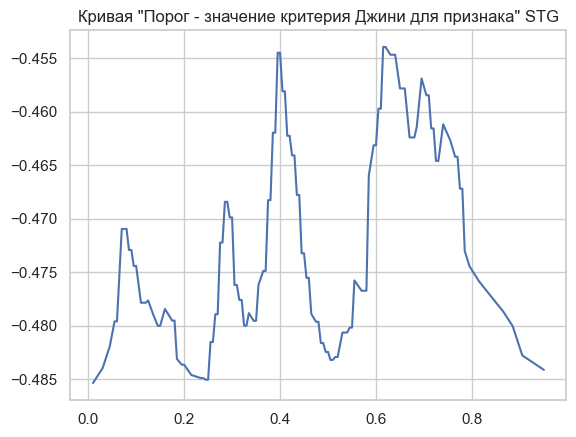

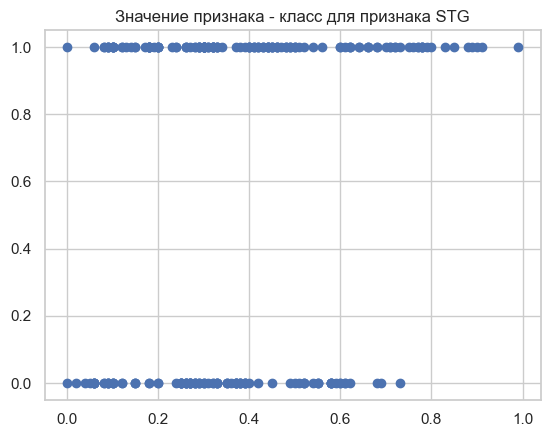

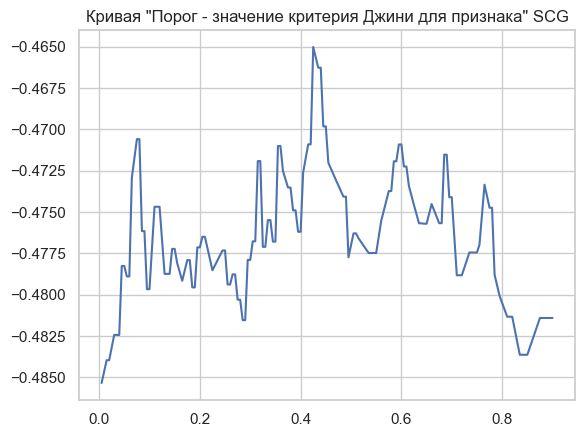

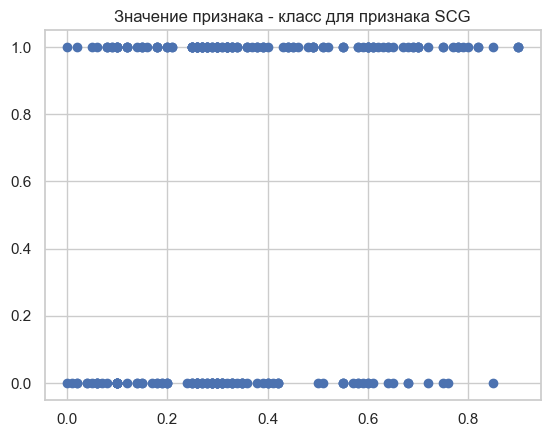

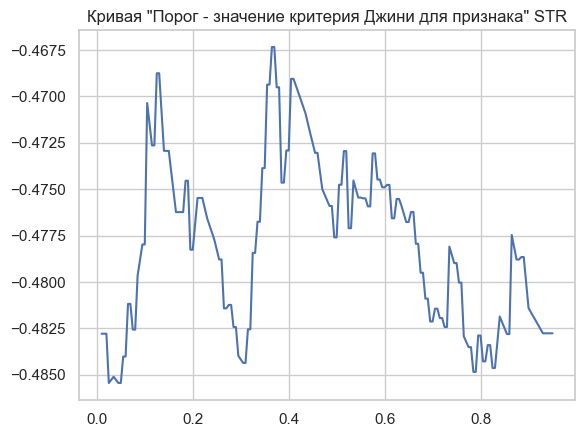

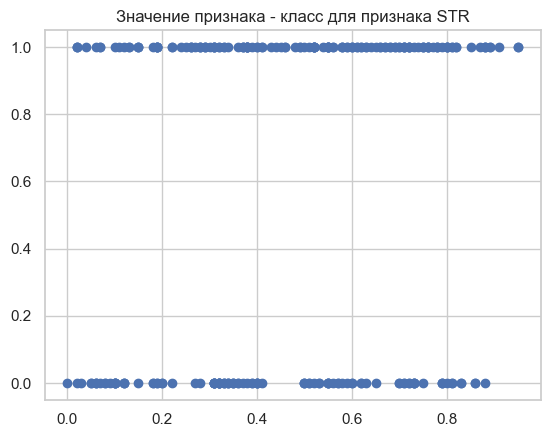

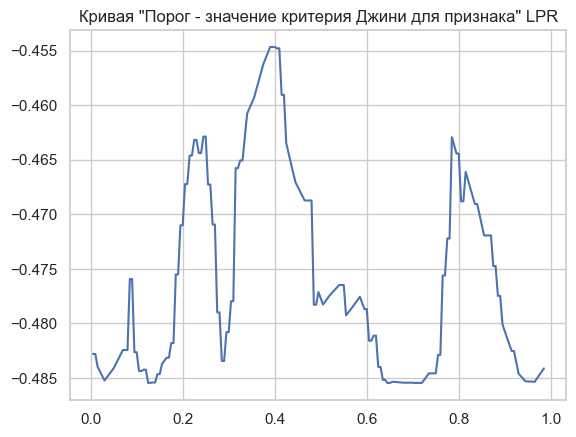

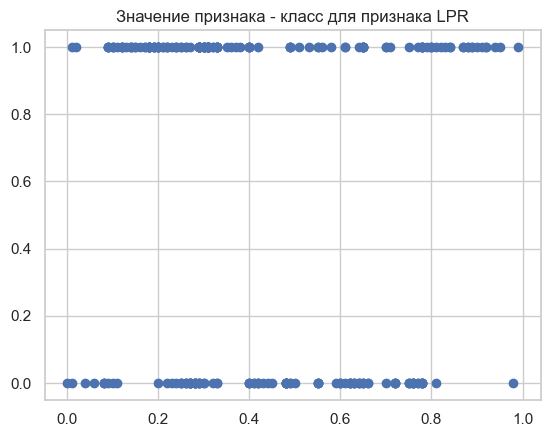

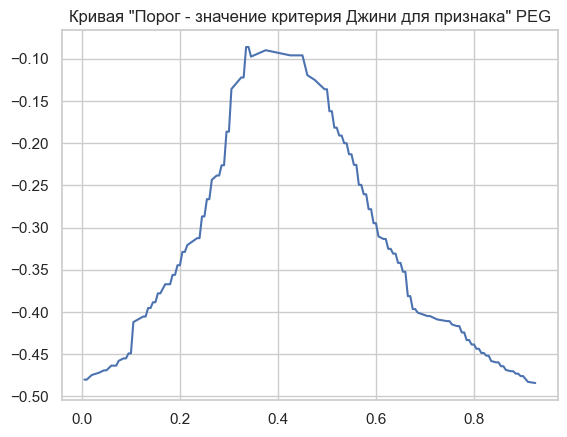

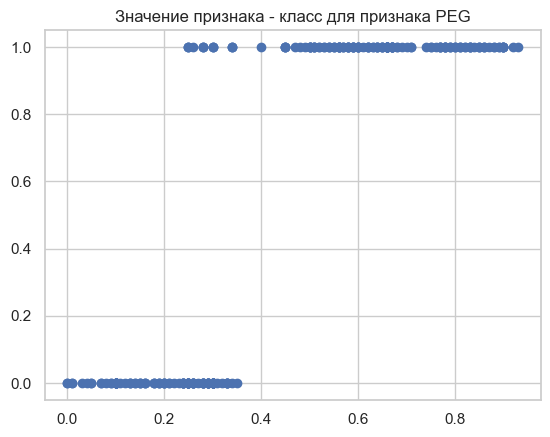

In [4]:
for col in students.drop(columns=['UNS']).columns:
    thresholds, ginis, threshold_best, gini_best = find_best_split(students[col], students['UNS'])
    plt.plot(thresholds, ginis)
    plt.title(f'Кривая \"Порог - значение критерия Джини для признака\" {col}')
    plt.show()
    plt.scatter(students[col], students['UNS'])
    plt.title(f'Значение признака - класс для признака {col}')
    plt.show()

### **Задание 3. (0.6 балла)**

Проанализируйтте построенные кривые. Ответьте на поставленные вопросы:
- По какому признаку нужно производить деление выборки на два поддерева? (0.15 балла)
- Согласуется ли этот результат с визуальной оценкой scatter-графиков? (0.15 балла)
- Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? (0.15 балла)
- Чем отличаются кривые для признаков, по которым деление практически невозможно? (0.15 балла)

**Ответ:**

`1. По признаку PEG: значение критерия Джини с отрицательным знаком в данном случае максимально (что нам и требуется для максимизации Information Gain)`

`2. Да, визуально можно увидеть пороговое значение (+- 0.4), которое разделяет классы.`

`3. Это кривая, имеющая ярко выраженный локальный максимум (желательно один).`

`4. Они имеют несколько локальных максимумов при совершенно разных пороговых значения, что затрудняет выбор наилучшего порога.`

### **Задание 4. (1.15 балла)**

В некоторых случаях необходимо анализировать код исполненного класса на предмет оптимальности и ошибок. Потренируйтесь в этом!

- Разберитесь с уже написанным кодом в классе DecisionTree модуля hw4_code_pro.py.
- Найдите ошибки в реализации метода \_fit_node.
- Напишите функцию \_predict_node.

**Примечание 1:**

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева».
- Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

**Примечание 2:**

- Выбор лучшего разбиения необходимо производить по критерию Джини.
- Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку, чтобы Джини упал
- Ответ в листе: наиболее часто встречающийся класс в листе.


### **Задание 5. (0.5 балла)**

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Для этого:

- Скачайте таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/))
- Прочитайте данные с помощью pandas
- Примените к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа.
- Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные)
- Сделайте предсказания для оставшейся половины.
- Вычислите accuracy (так как мы используем эту метрику и в силу задачи, нам не очень важно, что будет классом 1, а что — классом 0).  


У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [5]:
# читаем данные
mushrooms_url = 'https://archive.ics.uci.edu/static/public/73/mushroom.zip'
response = requests.get(mushrooms_url)
with io.BytesIO(response.content) as archive:
        with zipfile.ZipFile(archive) as zip_file:
            with zip_file.open('agaricus-lepiota.data') as data_file:
                    mushrooms = pd.read_csv(data_file)
mushrooms.head()

p  x  s  n  t p.1  f  c n.1  k  ... s.2  w w.1 p.2 w.2  o p.3 k.1 s.3  u
0  e  x  s  y  t   a  f  c   b  k  ...   s  w   w   p   w  o   p   n   n  g
1  e  b  s  w  t   l  f  c   b  n  ...   s  w   w   p   w  o   p   n   n  m
2  p  x  y  w  t   p  f  c   n  n  ...   s  w   w   p   w  o   p   k   s  u
3  e  x  s  g  f   n  f  w   b  k  ...   s  w   w   p   w  o   e   n   a  g
4  e  x  y  y  t   a  f  c   b  n  ...   s  w   w   p   w  o   p   k   n  g

[5 rows x 23 columns]

`Ознакомившись с файлом agaricus-lepiota.names понял (вроде как), что классы размечены в столбце "p": e=edible, p=poisonous. Всего 2 класса. Добавлю столбец target, содержащий только значения 1/0.`

In [6]:
mushrooms['target'] = np.where(mushrooms['p'] == 'p', 1, 0)
mushrooms['target'].value_counts()

target
0    4208
1    3915
Name: count, dtype: int64

In [7]:
# LabelEncoder
X, y = mushrooms.drop(columns=['target', 'p']), mushrooms['target']
for col in X.columns:
    X[f'{col}_'] = LabelEncoder().fit_transform(X[col])
X_encoded = X[X.columns[X.columns.str.endswith('_')]]

In [8]:
# половину объектов возьмем как обучающую выборку, половину как тестовую
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.5, random_state=42)

In [9]:
# обучаем решающее дерево
dt = DecisionTree(feature_types=['categorical']*22)
dt.fit(X_train, y_train)

In [10]:
print(f'Глубина обученнего дерева = {dt._depth}')

Глубина обученнего дерева = 8


In [11]:
# делаем предсказание на тестовой выборке
pred = dt.predict(X_test)
accuracy_score(y_test, pred)

1.0

In [12]:
from sklearn.preprocessing import OneHotEncoder
dtc = DecisionTreeClassifier()
encoder = OneHotEncoder()
X_train_encoded = encoder.fit_transform(X_train)
dtc.fit(X_train_encoded, y_train)
pred = dtc.predict(encoder.transform(X_test))
accuracy_score(y_test, pred)

1.0

In [13]:
dtc.get_depth()

8

`Значение глубины дерева и точности предсказания в моей реализации и в реализации sklearn совпадают :)`

### **Задание 6. (бонус, 1 балл)**

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующее задание).

In [14]:
tic_tac_toe_url = 'https://archive.ics.uci.edu/static/public/101/tic+tac+toe+endgame.zip'
response = requests.get(tic_tac_toe_url)
with io.BytesIO(response.content) as archive:
        with zipfile.ZipFile(archive) as zip_file:
            with zip_file.open('tic-tac-toe.data') as data_file:
                    tic_tac_toe_df = pd.read_csv(data_file)
tic_tac_toe_df['target'] = np.where(tic_tac_toe_df['positive'] == 'positive', 1, 0)
tic_tac_toe_X, tic_tac_toe_y = tic_tac_toe_df.drop(columns=['positive', 'target']), tic_tac_toe_df['target']
tic_tac_toe_X_train, tic_tac_toe_X_test, tic_tac_toe_y_train, tic_tac_toe_y_test = train_test_split(tic_tac_toe_X, tic_tac_toe_y, test_size=0.25, random_state=42)

100%|██████████| 10/10 [00:58<00:00,  5.81s/it]


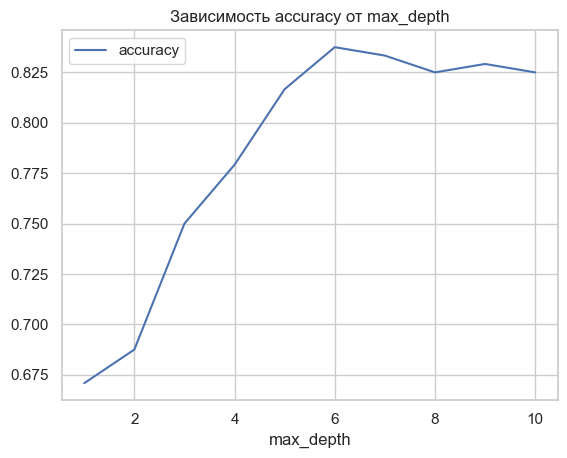

In [15]:
# перебираем max_depth
result = []
for max_depth_ in tqdm(np.arange(1, 11)):
    my_dt = DecisionTree(feature_types=['categorical']*9, max_depth=max_depth_)
    my_dt.fit(tic_tac_toe_X_train, tic_tac_toe_y_train)
    pred = my_dt.predict(tic_tac_toe_X_test)
    result.append((max_depth_, accuracy_score(tic_tac_toe_y_test, pred)))

pd.DataFrame(result, columns=['max_depth', 'accuracy']).plot(x='max_depth', y='accuracy')
plt.title('Зависимость accuracy от max_depth')
plt.show()

100%|██████████| 7/7 [00:40<00:00,  5.79s/it]


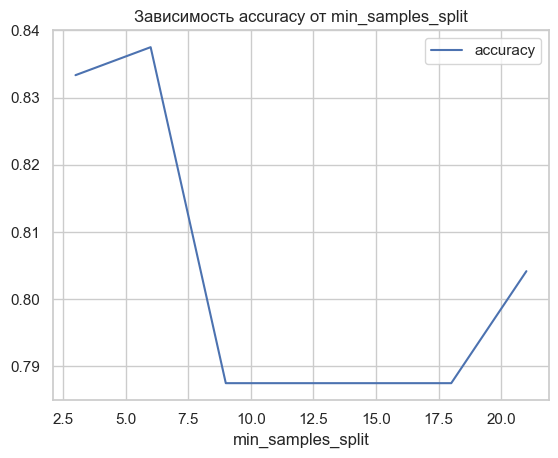

In [16]:
# перебираем min_samples_split
result = []
for min_samples_split_ in tqdm(np.arange(3, 22, 3)):
    my_dt = DecisionTree(feature_types=['categorical']*9, min_samples_split=min_samples_split_)
    my_dt.fit(tic_tac_toe_X_train, tic_tac_toe_y_train)
    pred = my_dt.predict(tic_tac_toe_X_test)
    result.append((min_samples_split_, accuracy_score(tic_tac_toe_y_test, pred)))

pd.DataFrame(result, columns=['min_samples_split', 'accuracy']).plot(x='min_samples_split', y='accuracy')
plt.xticks = np.arange(3, 22, 3)
plt.title('Зависимость accuracy от min_samples_split')
plt.show()

100%|██████████| 7/7 [00:43<00:00,  6.23s/it]


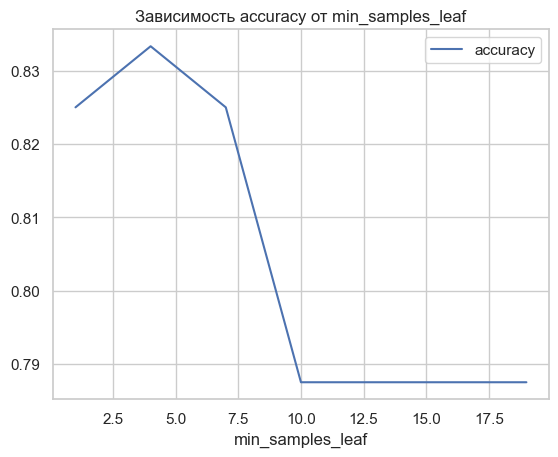

In [17]:
# перебираем min_samples_leaf
result = []
for min_samples_leaf_ in tqdm(np.arange(1, 22, 3)):
    my_dt = DecisionTree(feature_types=['categorical']*9, min_samples_leaf=min_samples_leaf_)
    my_dt.fit(tic_tac_toe_X_train, tic_tac_toe_y_train)
    pred = my_dt.predict(tic_tac_toe_X_test)
    result.append((min_samples_leaf_, accuracy_score(tic_tac_toe_y_test, pred)))

pd.DataFrame(result, columns=['min_samples_leaf', 'accuracy']).plot(x='min_samples_leaf', y='accuracy')
plt.xticks = np.arange(1, 22, 3)
plt.title('Зависимость accuracy от min_samples_leaf')
plt.show()

### **Задание 7. (2 балла)**

**1. Загрузите следующие наборы данных** (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (они записаны в Data Folder, в файле *.names):
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

**2. Закодируйте категориальные признаки, использовав LabelEncoder.** С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

**Рекомендации:**
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами.

```
Для каждого датасета:
1. Скачиваю zip-архив
2. Достаю data-файл
3. Читаю как pandas DataFrame
4. Создаю столбец target, в котором будут храниться прогнозируемые классы
5. Разделяю данные на X и y
```

In [482]:
# Датасет Mushrooms
mushrooms_url = 'https://archive.ics.uci.edu/static/public/73/mushroom.zip'
response = requests.get(mushrooms_url)
with io.BytesIO(response.content) as archive:
        with zipfile.ZipFile(archive) as zip_file:
            with zip_file.open('agaricus-lepiota.data') as data_file:
                    mushrooms_df = pd.read_csv(data_file)
mushrooms_df['target'] = np.where(mushrooms_df['p'] == 'p', 1, 0)
mushrooms_X, mushrooms_y = mushrooms_df.drop(columns=['p','target']), mushrooms_df['target']

In [483]:
# Датасет Tic-tac-toe
tic_tac_toe_url = 'https://archive.ics.uci.edu/static/public/101/tic+tac+toe+endgame.zip'
response = requests.get(tic_tac_toe_url)
with io.BytesIO(response.content) as archive:
        with zipfile.ZipFile(archive) as zip_file:
            with zip_file.open('tic-tac-toe.data') as data_file:
                    tic_tac_toe_df = pd.read_csv(data_file)
tic_tac_toe_df['target'] = np.where(tic_tac_toe_df['positive'] == 'positive', 1, 0)
tic_tac_toe_X, tic_tac_toe_y = tic_tac_toe_df.drop(columns=['positive', 'target']), tic_tac_toe_df['target']

In [484]:
# Датасет Cars
cars_url = 'https://archive.ics.uci.edu/static/public/19/car+evaluation.zip'
response = requests.get(cars_url)
with io.BytesIO(response.content) as archive:
        with zipfile.ZipFile(archive) as zip_file:
            with zip_file.open('car.data') as data_file:
                    cars_df = pd.read_csv(data_file)
cars_df['target'] = np.where(cars_df['unacc'].isin(['good', 'vgood']), 1, 0)
cars_X, cars_y = cars_df.drop(columns=['unacc', 'target']), cars_df['target']

In [485]:
# Датасет Nursery
nursery_url = 'https://archive.ics.uci.edu/static/public/76/nursery.zip'
response = requests.get(nursery_url)
with io.BytesIO(response.content) as archive:
        with zipfile.ZipFile(archive) as zip_file:
            with zip_file.open('nursery.data') as data_file:
                    nursery_df = pd.read_csv(data_file)
nursery_df['target'] = np.where(nursery_df['recommend'].isin(['very_recom', 'priority', 'spec_prior']), 1, 0)
nurserys_X, nursery_y = nursery_df.drop(columns=['recommend', 'target']), nursery_df['target']

In [486]:
# LabelEncoder-time

for col in mushrooms_X.columns:
    mushrooms_X[f'{col}_'] = LabelEncoder().fit_transform(mushrooms_X[col])
mushrooms_X_encoded = mushrooms_X[mushrooms_X.columns[mushrooms_X.columns.str.endswith('_')]]

for col in tic_tac_toe_X.columns:
    tic_tac_toe_X[f'{col}_'] = LabelEncoder().fit_transform(tic_tac_toe_X[col])
tic_tac_toe_X_encoded = tic_tac_toe_X[tic_tac_toe_X.columns[tic_tac_toe_X.columns.str.endswith('_')]]

for col in cars_X.columns:
    cars_X[f'{col}_'] = LabelEncoder().fit_transform(cars_X[col])
cars_X_encoded = cars_X[cars_X.columns[cars_X.columns.str.endswith('_')]]

for col in nurserys_X.columns:
    nurserys_X[f'{col}_'] = LabelEncoder().fit_transform(nurserys_X[col])
nurserys_X_encoded = nurserys_X[nurserys_X.columns[nurserys_X.columns.str.endswith('_')]]

In [ ]:
# оценим accuracy на каждом датасете с помощью вариаций решающего дерева

In [487]:
# собрал класс для датасета, чтобы было удобнее итерироваться далее

class Dataset():
    def __init__(self, X, y, name):
        self.X = X
        self.y = y
        self.name = name
datasets = [
    Dataset(mushrooms_X_encoded, mushrooms_y, 'mushrooms'), 
    Dataset(tic_tac_toe_X_encoded, tic_tac_toe_y, 'tic_tac_toe'),
    Dataset(cars_X_encoded, cars_y, 'cars'),
    Dataset(nurserys_X_encoded, nursery_y, 'nurserys')
]

`Здесь при выставлении cv=10 приходится ждать слишком долго, поэтому установил cv=4. Просьба понять и простить :)`

In [490]:
result = []
for dataset in tqdm(datasets):
    # Модель № 1: DecisionTree, считающий все признаки вещественными
    model1 = DecisionTree(feature_types=['real']*dataset.X.shape[1])
    model1_result = cross_val_score(model1, dataset.X, dataset.y, cv=4, scoring=make_scorer(accuracy_score)).mean()
    result.append(('model1', dataset.name, model1_result))
    print("Model 1 done!")

    # Модель № 2: DecisionTree, считающий все признаки категориальными
    model2 = DecisionTree(feature_types=['categorical']*dataset.X.shape[1])
    model2_result = cross_val_score(model2, dataset.X, dataset.y, cv=4, scoring=make_scorer(accuracy_score)).mean()
    result.append(('model2', dataset.name, model2_result))
    print("Model 2 done!")

    # Модель № 3: DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
    ohe_encoder = OneHotEncoder(sparse_output=False)
    X_transformed = ohe_encoder.fit_transform(dataset.X)
    model3 = DecisionTree(feature_types=['real']*X_transformed.shape[1])
    model3_result = cross_val_score(model3, X_transformed, dataset.y, cv=4, scoring=make_scorer(accuracy_score)).mean()
    result.append(('model3', dataset.name, model3_result))
    print("Model 3 done!")

    # Модель № 4: DecisionTreeClassifier из sklearn
    model4 = DecisionTreeClassifier()
    model4_result = cross_val_score(model4, dataset.X, dataset.y, cv=4, scoring=make_scorer(accuracy_score)).mean()
    result.append(('model4', dataset.name, model4_result))
    print("Model 4 done!")

  0%|          | 0/4 [00:00<?, ?it/s]

Model 1 done!
Model 2 done!


 25%|██▌       | 1/4 [49:07<2:27:23, 2947.96s/it]

Model 3 done!
Model 4 done!
Model 1 done!
Model 2 done!


 50%|█████     | 2/4 [50:53<42:32, 1276.23s/it]  

Model 3 done!
Model 4 done!
Model 1 done!
Model 2 done!


 75%|███████▌  | 3/4 [52:35<12:19, 739.76s/it] 

Model 3 done!
Model 4 done!
Model 1 done!
Model 2 done!


100%|██████████| 4/4 [1:10:14<00:00, 1053.51s/it]

Model 3 done!
Model 4 done!


In [494]:
result_df = pd.DataFrame(result, columns=['model', 'dataset', 'accuracy_score'])
result_df.pivot_table(index='dataset', values='accuracy_score', columns='model')

model          model1    model2    model3    model4
dataset                                            
cars         0.847108  0.903821  0.922340  0.827831
mushrooms    0.913954  0.956660  0.925650  0.889297
nurserys     0.999923  0.999923  0.999923  0.999846
tic_tac_toe  0.183586  0.197128  0.135669  0.769238

### **Задание 8. (0.5 балла)**

Проанализируйте результаты эксперимента. Ответьте на вопросы:
- Одинаково ли для разных наборов данных ранжируются алгоритмы?
Порассуждайте, почему так происходит.
- Обратите внимание на значение признаков в разных наборах данных.
Присутствует ли в результатах какая-то компонента случайности?
- Если случайность есть, то можно ли повлиять на нее и улушить работу алгоритмов?

Модель № 1: DecisionTree, считающий все признаки вещественными

Модель № 2: DecisionTree, считающий все признаки категориальными

Модель № 3: DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков

Модель № 4: DecisionTreeClassifier из sklearn

**Ответ:**
```
1. Нет, алгоритмы для разных наборов данных ранжируются по-разному. Возможно это связано с тем, что в некоторых датасетах можно провести гиперплоскости по признакам, хорошо разделяющие классы (модели 1 и 4), а в некоторых - нельзя (и здесь хороший результат показывает модели № 2 и №3). Например, значения вещественных признаков можно разделить только оператором ">=", в то время как категориальные можно взять вариативные (взять значение 1 и 3, но не брать 2 и тд). В данном случае модели 2 и 3 действую именно так.

2. В датасетах cars, mushrooms и tic_tac_toe присутствует компонента случайности. 

3. Чтобы улучшить модели и снизить эту компоненту стоить поработать над: гиперпараметрами модели, сделать feature engineering.

# **2. Задача бинарной классификации реализованным деревом (4 балла)**

Всего за эту часть можно получить 4 балла.

В этом разделе вам необходимо решить задачу бинарной классификации самописным деревом и лесом из sklearn, а после интерпретировать лучшие модели. А именно:

- Извлечь данные из базы данных;
- Предобработать датасет;
- Обучить собственный класс DT и RF из `sklearn` в как базовом варианте (гиперпараметры по умолчанию), так и с подбором гиперпараметров;
- Интерпретировать алгоритмы при помощи LIME или SHAP.


### **Познакомимся с задачей: постановка**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

In [27]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

zsh:1: command not found: wget


### **Задание 9. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

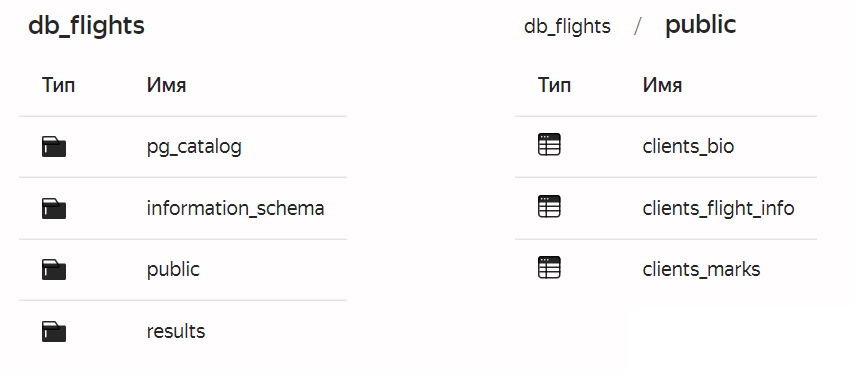

In [2]:
import psycopg2
import pandas as pd
conn = psycopg2.connect(
    host="rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net",
    port="6432",
    dbname="db_flights", 
    user="mlhs_student", 
    password="mlhs_student",
    sslmode="verify-full",
    target_session_attrs="read-write"
)


In [3]:
df = pd.read_sql_query(
'''

SELECT 
flights.id,
flights."Customer Type",
flights."Type of Travel",
flights."class",
flights."Flight Distance",
flights."Departure Delay in Minutes",
flights."Arrival Delay in Minutes",
marks."Inflight wifi service", 
marks."Departure/Arrival time convenient",
marks."Ease of Online booking", 
marks."Gate location", 
marks."Food and drink",
marks."Online boarding", 
marks."Seat comfort", 
marks."Inflight entertainment",
marks."On-board service", 
marks."Leg room service", 
marks."Baggage handling",
marks."Checkin service", 
marks."Inflight service", 
marks."cleanliness", 
marks."satisfaction",
clients."gender",
clients."age"

FROM db_flights.public.clients_flight_info as flights
inner join db_flights.public.clients_marks as marks on marks.id = flights.id
inner join db_flights.public.clients_bio as clients on clients.id = flights.id

''', con=conn)

df.head()

id      Customer Type   Type of Travel     class Flight Distance  \
0   7     Loyal Customer  Business travel  Business          1963.0   
1  13  disloyal Customer  Business travel       Eco           453.0   
2  18     Loyal Customer  Personal Travel       Eco           821.0   
3  31  disloyal Customer  Business travel  Business           212.0   
4  39     Loyal Customer  Business travel  Business            67.0   

  Departure Delay in Minutes Arrival Delay in Minutes Inflight wifi service  \
0                        0.0                      0.0                   3.0   
1                       16.0                     30.0                   2.0   
2                        0.0                      0.0                   2.0   
3                        0.0                      0.0                   2.0   
4                        0.0                      0.0                   3.0   

  Departure/Arrival time convenient Ease of Online booking  ...  \
0                               3.0                    3.0  ...   
1                               2.0                    2.0  ...   
2                               5.0                    2.0  ...   
3                               2.0                    2.0  ...   
4                               3.0                    3.0  ...   

  Inflight entertainment On-board service Leg room service Baggage handling  \
0                    5.0              5.0              5.0              5.0   
1                    5.0              2.0              4.0              4.0   
2                    5.0              5.0              2.0              5.0   
3                    2.0              4.0              5.0              5.0   
4                    4.0              4.0              4.0              4.0   

  Checkin service Inflight service cleanliness             satisfaction  \
0             4.0              5.0         4.0                satisfied   
1             2.0              4.0         5.0  neutral or dissatisfied   
2             5.0              5.0         1.0  neutral or dissatisfied   
3             5.0              4.0         2.0  neutral or dissatisfied   
4             5.0              4.0         5.0                satisfied   

   gender   age  
0    Male  43.0  
1    Male  24.0  
2  Female  61.0  
3    Male  35.0  
4  Female  46.0  

[5 rows x 24 columns]

In [4]:
df.index = df['id']
df = df.drop(columns=['id'])
conn.close()

In [5]:
assert df.shape == (129_549, 23)

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [6]:
df_train = df[df.satisfaction != '-']

df_train.head()

Customer Type   Type of Travel     class Flight Distance  \
id                                                                 
7      Loyal Customer  Business travel  Business          1963.0   
13  disloyal Customer  Business travel       Eco           453.0   
18     Loyal Customer  Personal Travel       Eco           821.0   
31  disloyal Customer  Business travel  Business           212.0   
39     Loyal Customer  Business travel  Business            67.0   

   Departure Delay in Minutes Arrival Delay in Minutes Inflight wifi service  \
id                                                                             
7                         0.0                      0.0                   3.0   
13                       16.0                     30.0                   2.0   
18                        0.0                      0.0                   2.0   
31                        0.0                      0.0                   2.0   
39                        0.0                      0.0                   3.0   

   Departure/Arrival time convenient Ease of Online booking Gate location  \
id                                                                          
7                                3.0                    3.0           3.0   
13                               2.0                    2.0           4.0   
18                               5.0                    2.0           1.0   
31                               2.0                    2.0           1.0   
39                               3.0                    3.0           3.0   

    ... Inflight entertainment On-board service Leg room service  \
id  ...                                                            
7   ...                    5.0              5.0              5.0   
13  ...                    5.0              2.0              4.0   
18  ...                    5.0              5.0              2.0   
31  ...                    2.0              4.0              5.0   
39  ...                    4.0              4.0              4.0   

   Baggage handling Checkin service Inflight service cleanliness  \
id                                                                 
7               5.0             4.0              5.0         4.0   
13              4.0             2.0              4.0         5.0   
18              5.0             5.0              5.0         1.0   
31              5.0             5.0              4.0         2.0   
39              4.0             5.0              4.0         5.0   

               satisfaction  gender   age  
id                                         
7                 satisfied    Male  43.0  
13  neutral or dissatisfied    Male  24.0  
18  neutral or dissatisfied  Female  61.0  
31  neutral or dissatisfied    Male  35.0  
39                satisfied  Female  46.0  

[5 rows x 23 columns]

In [7]:
assert df_train.shape == (103_644, 23)

In [8]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test.head()

Customer Type   Type of Travel     class Flight Distance  \
id                                                               
55   Loyal Customer  Business travel  Business          3655.0   
79   Loyal Customer  Personal Travel       Eco           108.0   
126  Loyal Customer  Personal Travel       Eco           562.0   
199  Loyal Customer  Business travel  Business          3756.0   
263  Loyal Customer  Personal Travel  Business           802.0   

    Departure Delay in Minutes Arrival Delay in Minutes Inflight wifi service  \
id                                                                              
55                        40.0                     71.0                   1.0   
79                        50.0                     41.0                   5.0   
126                       88.0                     84.0                   2.0   
199                       36.0                     24.0                   4.0   
263                        0.0                      0.0                   1.0   

    Departure/Arrival time convenient Ease of Online booking Gate location  \
id                                                                           
55                                1.0                    1.0           1.0   
79                                4.0                    0.0           3.0   
126                               5.0                    2.0           4.0   
199                               4.0                    4.0           4.0   
263                               2.0                    1.0           3.0   

     ... Seat comfort Inflight entertainment On-board service  \
id   ...                                                        
55   ...          3.0                    3.0              3.0   
79   ...          4.0                    3.0              3.0   
126  ...          5.0                    5.0              3.0   
199  ...          5.0                    4.0              4.0   
263  ...          3.0                    2.0              2.0   

    Leg room service Baggage handling Checkin service Inflight service  \
id                                                                       
55               3.0              1.0             4.0              3.0   
79               0.0              3.0             5.0              3.0   
126              5.0              2.0             5.0              5.0   
199              4.0              4.0             5.0              4.0   
263              1.0              2.0             3.0              2.0   

    cleanliness  gender   age  
id                             
55          2.0    Male  36.0  
79          5.0  Female  70.0  
126         5.0    Male  66.0  
199         5.0  Female  60.0  
263         1.0    Male  43.0  

[5 rows x 22 columns]

In [9]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид.

In [10]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [11]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 10 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)
- Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.
- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

In [12]:
num_cols = ['Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'Inflight wifi service', 'Departure/Arrival time convenient',
       'Ease of Online booking', 'Gate location', 'Food and drink',
       'Online boarding', 'Seat comfort', 'Inflight entertainment',
       'On-board service', 'Leg room service', 'Baggage handling',
       'Checkin service', 'Inflight service', 'cleanliness', 'age']
cat_cols = list(X_train.drop(columns=num_cols).columns)

In [13]:
# преобразование числовых столбцов в float
X_train[num_cols] = X_train[num_cols].astype(float)
X_val[num_cols] = X_val[num_cols].astype(float)

In [14]:
# пропуски
X_train.isna().sum()

Customer Type                          0
Type of Travel                         0
class                                  0
Flight Distance                       54
Departure Delay in Minutes            61
Arrival Delay in Minutes             294
Inflight wifi service                 23
Departure/Arrival time convenient     28
Ease of Online booking                24
Gate location                         19
Food and drink                        22
Online boarding                       23
Seat comfort                          23
Inflight entertainment                30
On-board service                      23
Leg room service                      22
Baggage handling                      21
Checkin service                       22
Inflight service                      30
cleanliness                           21
gender                                 0
age                                  185
dtype: int64

In [15]:
X_val.isna().sum()

Customer Type                          0
Type of Travel                         0
class                                  0
Flight Distance                       18
Departure Delay in Minutes            23
Arrival Delay in Minutes             111
Inflight wifi service                  9
Departure/Arrival time convenient     13
Ease of Online booking                 9
Gate location                         11
Food and drink                        13
Online boarding                       14
Seat comfort                          18
Inflight entertainment                12
On-board service                       9
Leg room service                      14
Baggage handling                      11
Checkin service                       12
Inflight service                      19
cleanliness                           10
gender                                 0
age                                   76
dtype: int64

In [16]:
for col in cat_cols:
    print(col)
    print(X_train[col].unique())

Customer Type
['disloyal Customer' 'Loyal Customer' 'nan']
Type of Travel
['Business travel' 'Personal Travel' 'nan']
class
['Business' 'Eco' 'Eco Plus' 'nan']
gender
['Female' 'Male']


In [17]:
for col in cat_cols:
    print(col)
    print(X_val[col].unique())

Customer Type
['Loyal Customer' 'disloyal Customer' 'nan']
Type of Travel
['Business travel' 'Personal Travel' 'nan']
class
['Business' 'Eco' 'Eco Plus' 'nan']
gender
['Male' 'Female']


`Да, в датафрейме есть пропуски... Метод isna() показывает, что пропуски есть только в вещественных столбцах, а в категориальных их нет. Но посмотрев уникальные значения категориальных признаков видно, что здесь пропуски заполнены строками 'nan'.`

In [18]:
X_train[num_cols].describe()

Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
count     72496.000000                72489.000000              72256.000000   
mean       1329.757256                   15.872712                 16.713699   
std        4766.066508                   70.890252                 98.183683   
min           0.000000                    0.000000                  0.000000   
25%         413.000000                    0.000000                  0.000000   
50%         844.000000                    0.000000                  0.000000   
75%        1744.000000                   13.000000                 13.000000   
max      379620.000000                 9282.000000              11760.000000   

       Inflight wifi service  Departure/Arrival time convenient  \
count           72527.000000                       72522.000000   
mean                2.733603                           3.064656   
std                 1.362380                           1.552445   
min                 0.000000                           0.000000   
25%                 2.000000                           2.000000   
50%                 3.000000                           3.000000   
75%                 4.000000                           4.000000   
max                45.000000                          45.000000   

       Ease of Online booking  Gate location  Food and drink  Online boarding  \
count            72526.000000   72531.000000    72528.000000     72527.000000   
mean                 2.760927       2.982683        3.209078         3.256277   
std                  1.415070       1.316821        1.350097         1.372893   
min                  0.000000       0.000000        0.000000         0.000000   
25%                  2.000000       2.000000        2.000000         2.000000   
50%                  3.000000       3.000000        3.000000         3.000000   
75%                  4.000000       4.000000        4.000000         4.000000   
max                 28.000000      36.000000       36.000000        32.000000   

       Seat comfort  Inflight entertainment  On-board service  \
count  72527.000000            72520.000000      72527.000000   
mean       3.445489                3.361886          3.382906   
std        1.346255                1.361082          1.333924   
min        0.000000                0.000000          0.000000   
25%        2.000000                2.000000          2.000000   
50%        4.000000                4.000000          4.000000   
75%        5.000000                4.000000          4.000000   
max       45.000000               40.000000         45.000000   

       Leg room service  Baggage handling  Checkin service  Inflight service  \
count      72528.000000      72529.000000     72528.000000      72520.000000   
mean           3.352167          3.630148         3.308846          3.640085   
std            1.360340          1.228015         1.293254          1.215343   
min            0.000000          0.000000         0.000000          0.000000   
25%            2.000000          3.000000         3.000000          3.000000   
50%            4.000000          4.000000         3.000000          4.000000   
75%            4.000000          5.000000         4.000000          5.000000   
max           36.000000         40.000000        45.000000         36.000000   

        cleanliness           age  
count  72529.000000  72365.000000  
mean       3.290973     40.101665  
std        1.343443     20.684510  
min        0.000000      0.000000  
25%        2.000000     27.000000  
50%        3.000000     40.000000  
75%        4.000000     51.000000  
max       45.000000    544.000000

In [19]:
X_val[num_cols].describe()

Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
count     31076.000000                31071.000000              30983.000000   
mean       1317.036813                   15.678543                 16.932221   
std        4380.208274                   80.687099                131.334310   
min           0.000000                    0.000000                  0.000000   
25%         417.000000                    0.000000                  0.000000   
50%         846.000000                    0.000000                  0.000000   
75%        1744.000000                   12.000000                 13.000000   
max      255522.000000                11011.000000              14006.000000   

       Inflight wifi service  Departure/Arrival time convenient  \
count           31085.000000                       31081.000000   
mean                2.732443                           3.064445   
std                 1.348225                           1.558779   
min                 0.000000                           0.000000   
25%                 2.000000                           2.000000   
50%                 3.000000                           3.000000   
75%                 4.000000                           4.000000   
max                40.000000                          35.000000   

       Ease of Online booking  Gate location  Food and drink  Online boarding  \
count            31085.000000   31083.000000    31081.000000     31080.000000   
mean                 2.758919       2.978187        3.194878         3.252252   
std                  1.439213       1.290719        1.359113         1.414854   
min                  0.000000       1.000000        0.000000         0.000000   
25%                  2.000000       2.000000        2.000000         2.000000   
50%                  3.000000       3.000000        3.000000         3.000000   
75%                  4.000000       4.000000        4.000000         4.000000   
max                 45.000000      32.000000       45.000000        40.000000   

       Seat comfort  Inflight entertainment  On-board service  \
count  31076.000000            31082.000000      31085.000000   
mean       3.438152                3.359018          3.394402   
std        1.356800                1.358737          1.337166   
min        0.000000                0.000000          0.000000   
25%        2.000000                2.000000          2.000000   
50%        4.000000                4.000000          4.000000   
75%        5.000000                4.000000          4.000000   
max       36.000000               36.000000         40.000000   

       Leg room service  Baggage handling  Checkin service  Inflight service  \
count      31080.000000      31083.000000     31082.000000      31075.000000   
mean           3.367471          3.648650         3.306640          3.655093   
std            1.379782          1.224415         1.322056          1.204747   
min            0.000000          1.000000         0.000000          1.000000   
25%            2.000000          3.000000         3.000000          3.000000   
50%            4.000000          4.000000         3.000000          4.000000   
75%            4.000000          5.000000         4.000000          5.000000   
max           40.000000         40.000000        45.000000         35.000000   

        cleanliness           age  
count  31084.000000  31018.000000  
mean       3.286546     39.958121  
std        1.345512     19.573370  
min        0.000000      0.000000  
25%        2.000000     27.000000  
50%        3.000000     40.000000  
75%        4.000000     51.000000  
max       40.000000    612.000000

`Выбросы в датафрейме тоже есть :(`

In [20]:
# заполню пропуски наиболее часто встречающимися значениями
# данные значения я вычислю на основе обучающей выборке, заполню и обучающие данные, и тестовые.

# категориальные признаки
for col in cat_cols:
    most_frequent_value = X_train[col].value_counts().reset_index()[col].iloc[0]
    X_train.loc[X_train[col] == 'nan', col] = most_frequent_value
    X_val.loc[X_val[col] == 'nan', col] = most_frequent_value

# числовые признаки
# тут из ТЗ заполняю пропуски модой, хотя я имхо лучше бы заполнил медианой
for col in num_cols:
    most_frequent_value = X_train[col].value_counts().reset_index()[col].iloc[0]
    X_train[col] = X_train[col].fillna(most_frequent_value)
    X_val[col] = X_val[col].fillna(most_frequent_value)

In [21]:
# основные статистики по числовым столбцам
X_train[num_cols].describe()

Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
count     72550.000000                72550.000000              72550.000000   
mean       1329.018332                   15.859366                 16.645968   
std        4764.369357                   70.861937                 97.990293   
min           0.000000                    0.000000                  0.000000   
25%         413.000000                    0.000000                  0.000000   
50%         844.000000                    0.000000                  0.000000   
75%        1744.000000                   12.000000                 13.000000   
max      379620.000000                 9282.000000              11760.000000   

       Inflight wifi service  Departure/Arrival time convenient  \
count           72550.000000                       72550.000000   
mean                2.733687                           3.065017   
std                 1.362172                           1.552254   
min                 0.000000                           0.000000   
25%                 2.000000                           2.000000   
50%                 3.000000                           3.000000   
75%                 4.000000                           4.000000   
max                45.000000                          45.000000   

       Ease of Online booking  Gate location  Food and drink  Online boarding  \
count            72550.000000   72550.000000    72550.000000     72550.000000   
mean                 2.761006       2.982688        3.209318         3.256513   
std                  1.414843       1.316648        1.349963         1.372739   
min                  0.000000       0.000000        0.000000         0.000000   
25%                  2.000000       2.000000        2.000000         2.000000   
50%                  3.000000       3.000000        3.000000         3.000000   
75%                  4.000000       4.000000        4.000000         4.000000   
max                 28.000000      36.000000       36.000000        32.000000   

       Seat comfort  Inflight entertainment  On-board service  \
count  72550.000000            72550.000000      72550.000000   
mean       3.445665                3.362150          3.383101   
std        1.346077                1.360862          1.333758   
min        0.000000                0.000000          0.000000   
25%        2.000000                2.000000          2.000000   
50%        4.000000                4.000000          4.000000   
75%        5.000000                4.000000          4.000000   
max       45.000000               40.000000         45.000000   

       Leg room service  Baggage handling  Checkin service  Inflight service  \
count      72550.000000      72550.000000     72550.000000      72550.000000   
mean           3.352364          3.630255         3.309056          3.640234   
std            1.360180          1.227853         1.293114          1.215114   
min            0.000000          0.000000         0.000000          0.000000   
25%            2.000000          3.000000         3.000000          3.000000   
50%            4.000000          4.000000         3.000000          4.000000   
75%            4.000000          5.000000         4.000000          5.000000   
max           36.000000         40.000000        45.000000         36.000000   

        cleanliness           age  
count  72550.000000  72550.000000  
mean       3.291178     40.098856  
std        1.343302     20.658196  
min        0.000000      0.000000  
25%        2.000000     27.000000  
50%        3.000000     40.000000  
75%        4.000000     51.000000  
max       45.000000    544.000000

In [22]:
X_val[num_cols].describe()

Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
count     31094.000000                31094.000000              31094.000000   
mean       1316.469480                   15.666945                 16.871776   
std        4379.003672                   80.658377                131.103562   
min           0.000000                    0.000000                  0.000000   
25%         417.000000                    0.000000                  0.000000   
50%         845.000000                    0.000000                  0.000000   
75%        1744.000000                   12.000000                 13.000000   
max      255522.000000                11011.000000              14006.000000   

       Inflight wifi service  Departure/Arrival time convenient  \
count           31094.000000                       31094.000000   
mean                2.732521                           3.064836   
std                 1.348038                           1.558570   
min                 0.000000                           0.000000   
25%                 2.000000                           2.000000   
50%                 3.000000                           3.000000   
75%                 4.000000                           4.000000   
max                40.000000                          35.000000   

       Ease of Online booking  Gate location  Food and drink  Online boarding  \
count            31094.000000   31094.000000    31094.000000     31094.000000   
mean                 2.758989       2.978195        3.195215         3.252589   
std                  1.439010       1.290490        1.358929         1.414625   
min                  0.000000       1.000000        0.000000         0.000000   
25%                  2.000000       2.000000        2.000000         2.000000   
50%                  3.000000       3.000000        3.000000         3.000000   
75%                  4.000000       4.000000        4.000000         4.000000   
max                 45.000000      32.000000       45.000000        40.000000   

       Seat comfort  Inflight entertainment  On-board service  \
count  31094.000000            31094.000000      31094.000000   
mean       3.438477                3.359265          3.394578   
std        1.356474                1.358533          1.337013   
min        0.000000                0.000000          0.000000   
25%        2.000000                2.000000          2.000000   
50%        4.000000                4.000000          4.000000   
75%        5.000000                4.000000          4.000000   
max       36.000000               36.000000         40.000000   

       Leg room service  Baggage handling  Checkin service  Inflight service  \
count      31094.000000      31094.000000     31094.000000      31094.000000   
mean           3.367756          3.648775         3.306908          3.655303   
std            1.379536          1.224217         1.321872          1.204409   
min            0.000000          1.000000         0.000000          1.000000   
25%            2.000000          3.000000         3.000000          3.000000   
50%            4.000000          4.000000         3.000000          4.000000   
75%            4.000000          5.000000         4.000000          5.000000   
max           40.000000         40.000000        45.000000         35.000000   

        cleanliness           age  
count  31094.000000  31094.000000  
mean       3.286776     39.955779  
std        1.345356     19.549492  
min        0.000000      0.000000  
25%        2.000000     27.000000  
50%        3.000000     40.000000  
75%        4.000000     51.000000  
max       40.000000    612.000000

In [23]:
# основные статистики по категориальным столбцам
X_train[cat_cols].describe()

Customer Type   Type of Travel     class  gender
count            72550            72550     72550   72550
unique               2                2         3       2
top     Loyal Customer  Business travel  Business  Female
freq             59406            50054     34793   36816

In [24]:
X_val[cat_cols].describe()

Customer Type   Type of Travel     class  gender
count            31094            31094     31094   31094
unique               2                2         3       2
top     Loyal Customer  Business travel  Business  Female
freq             25315            21457     14783   15774

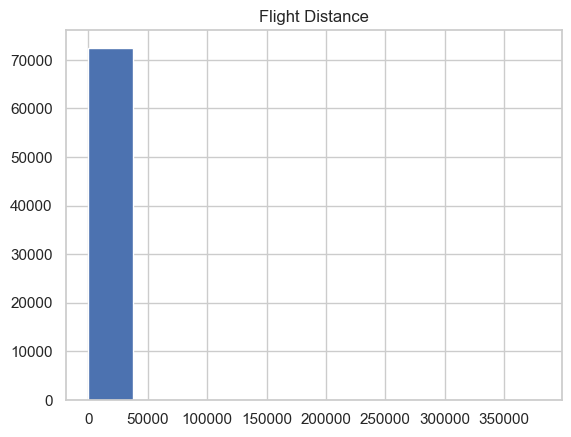

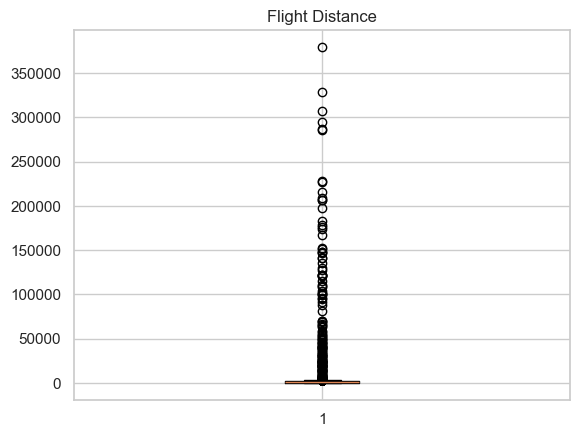

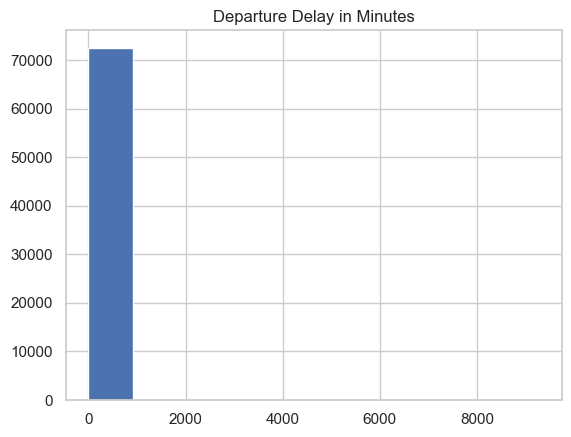

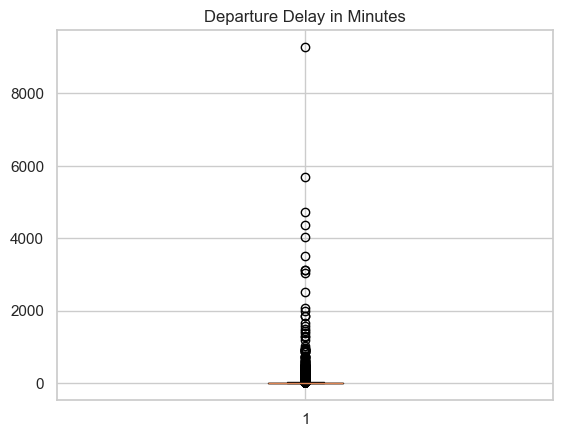

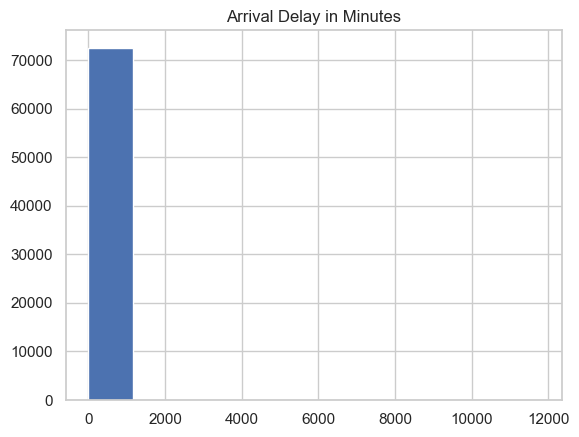

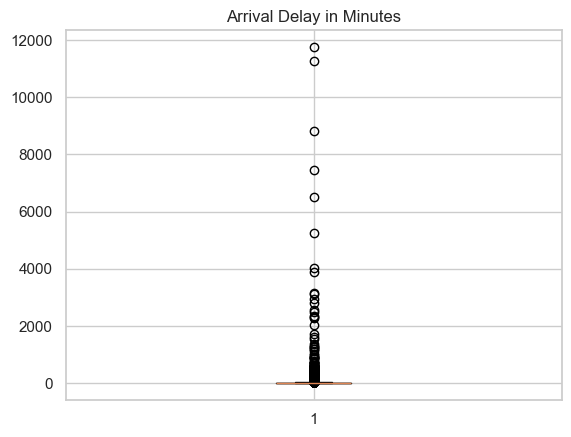

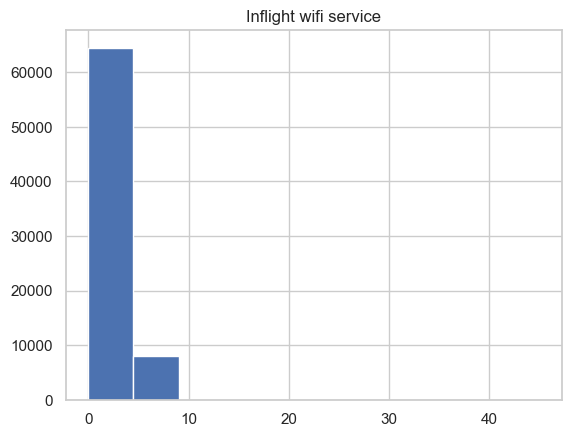

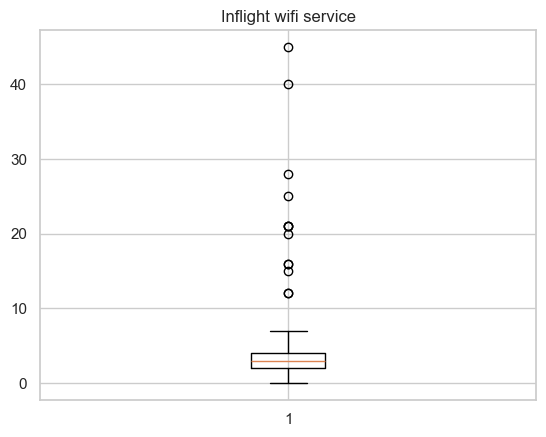

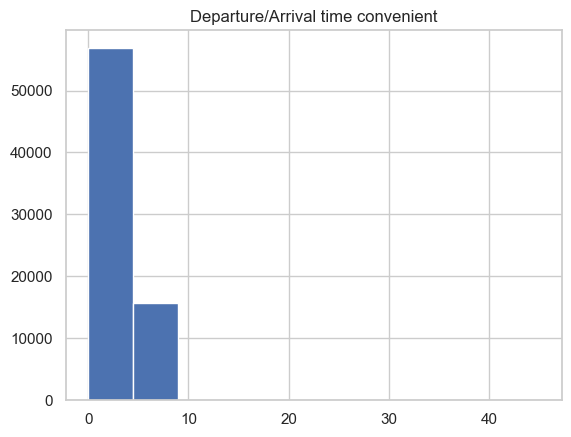

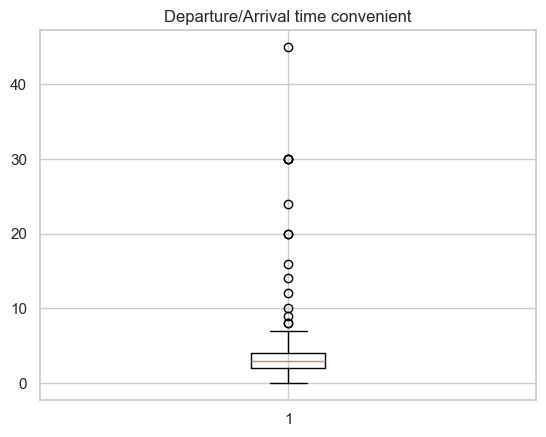

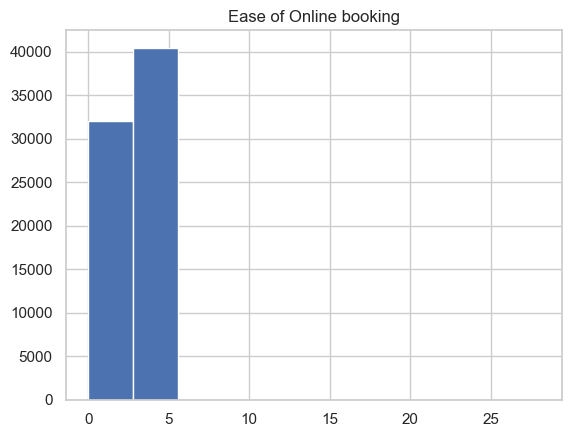

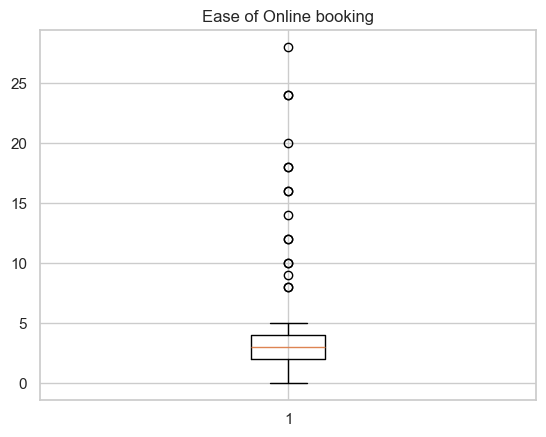

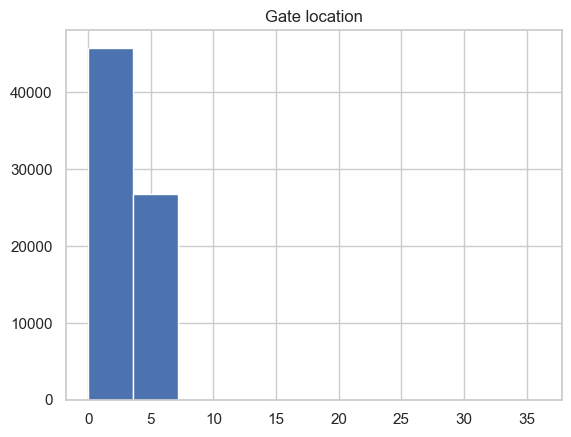

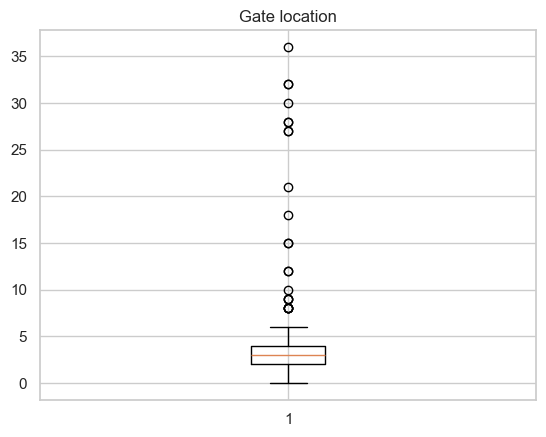

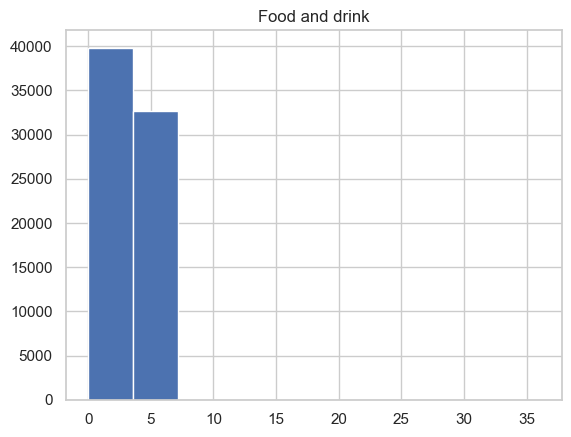

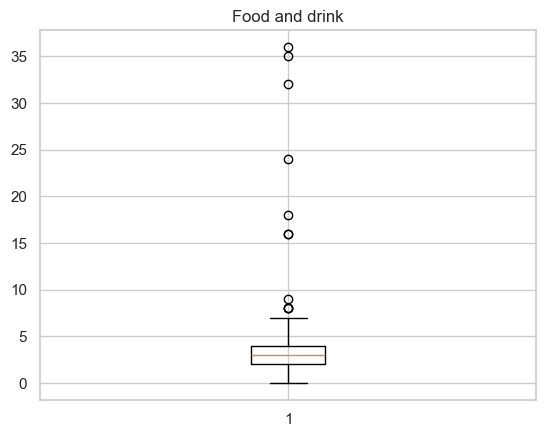

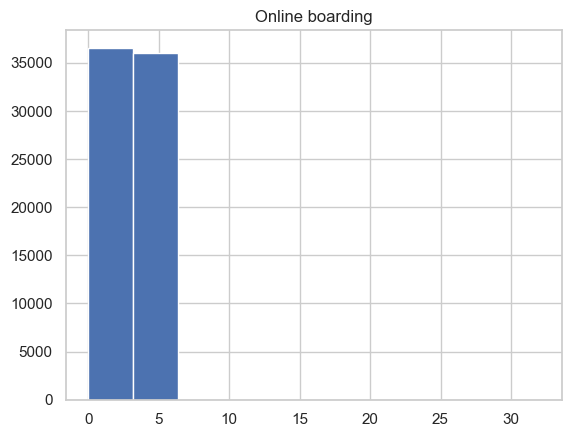

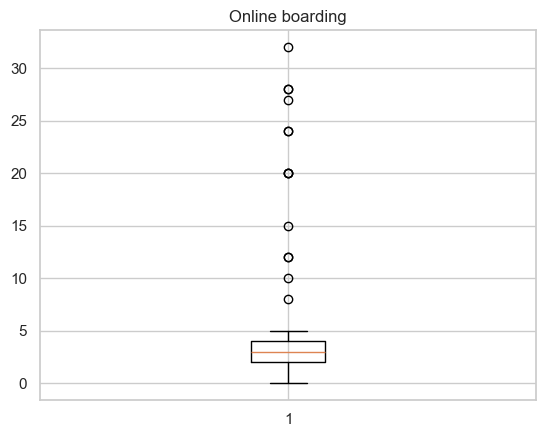

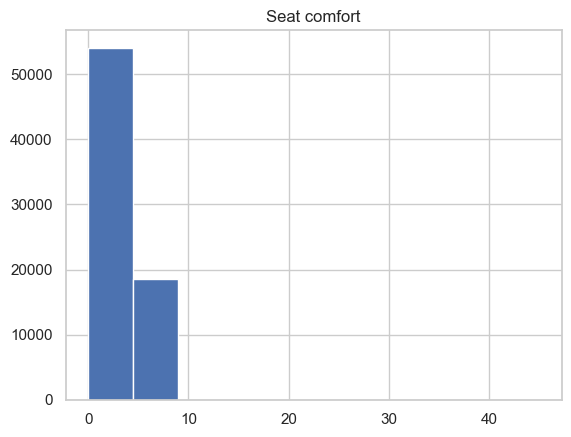

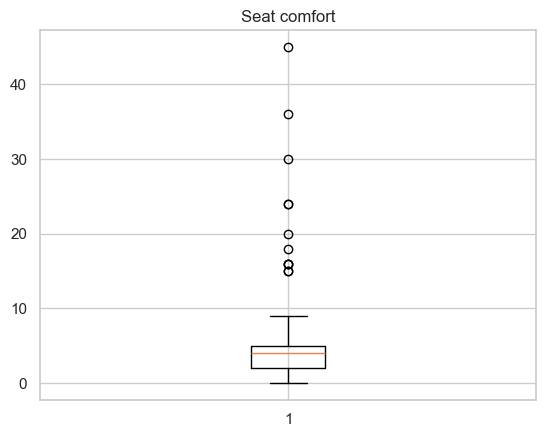

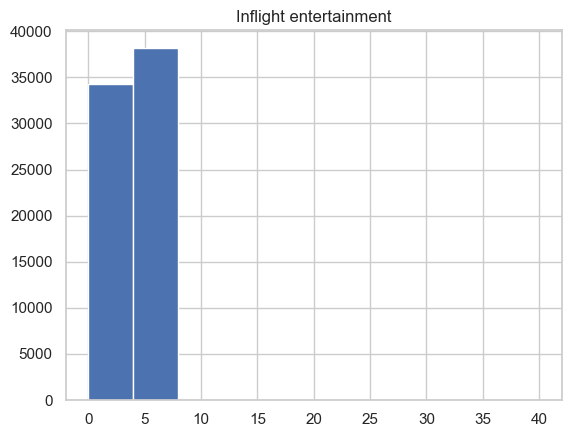

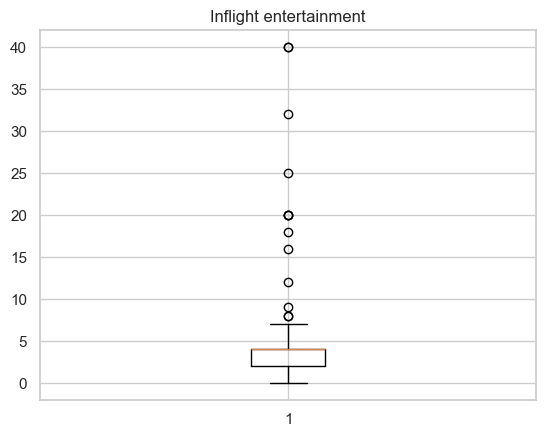

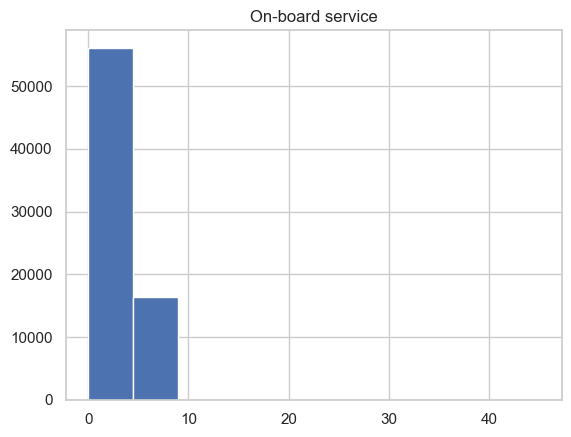

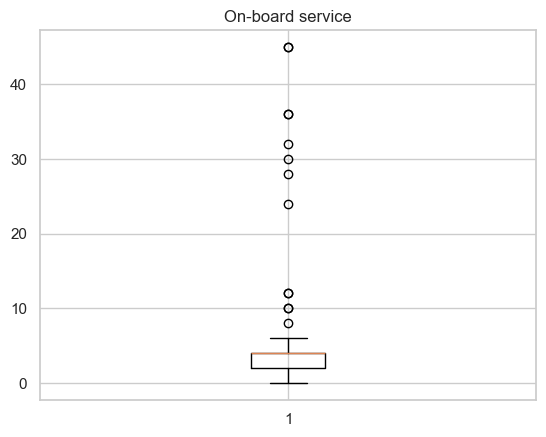

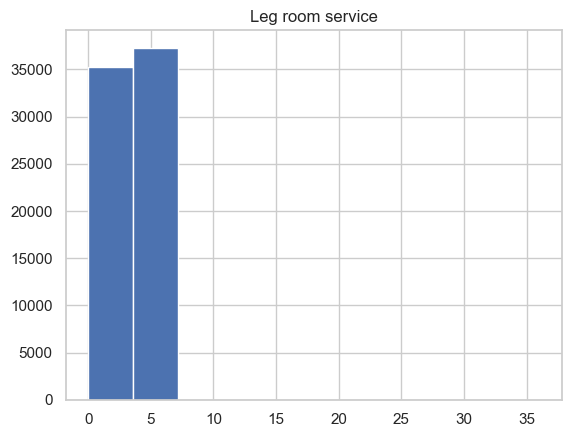

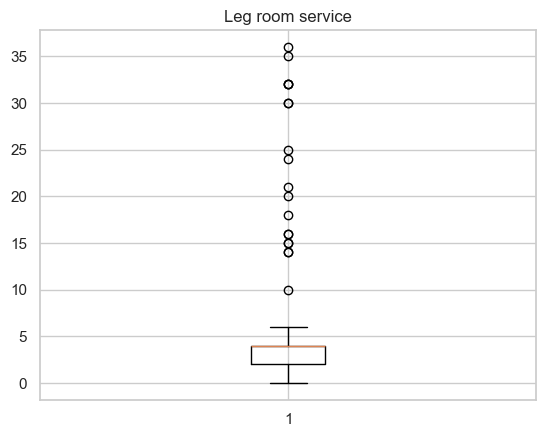

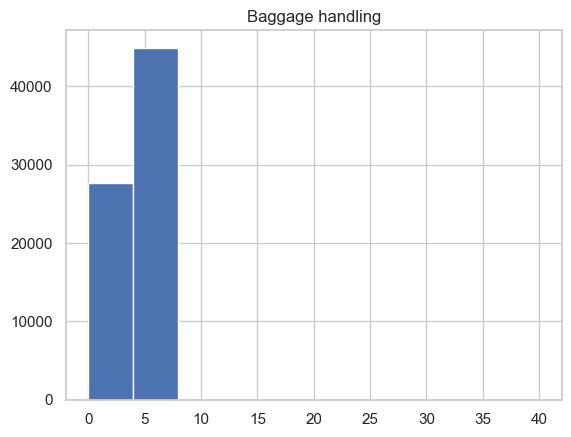

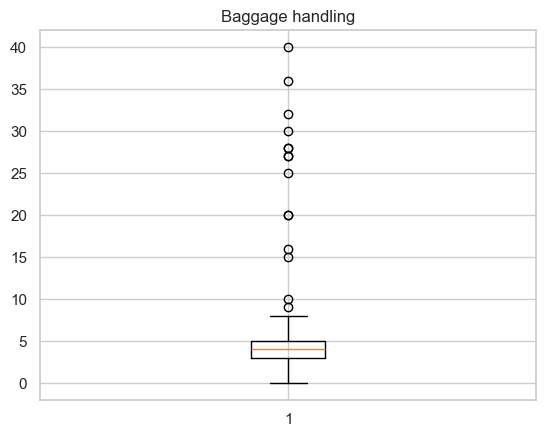

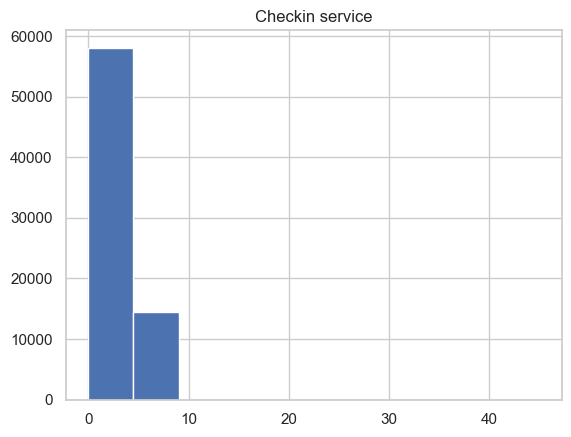

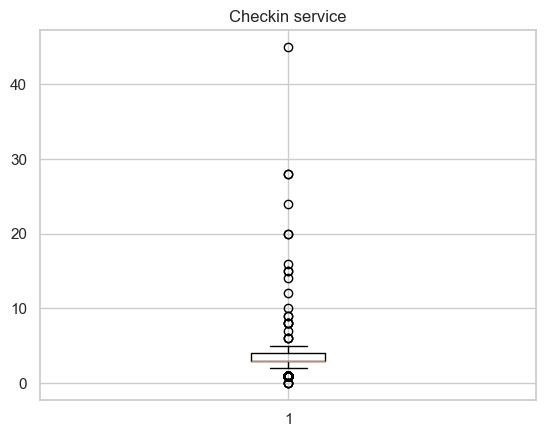

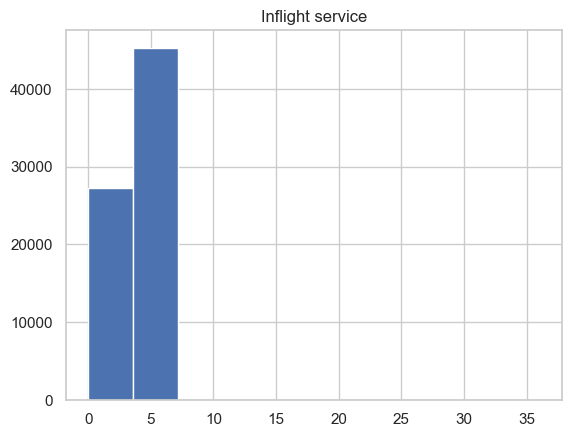

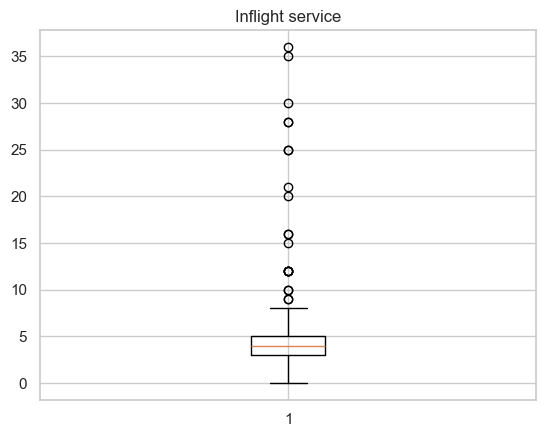

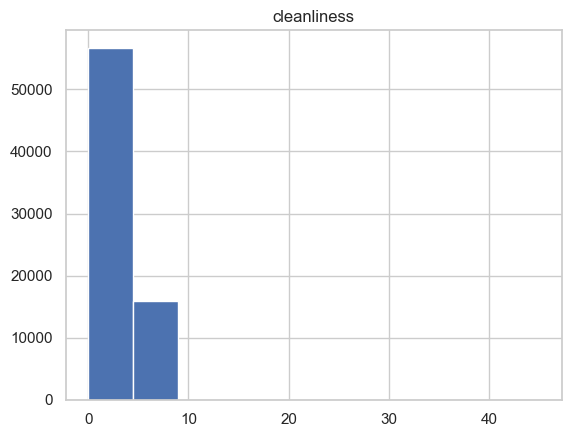

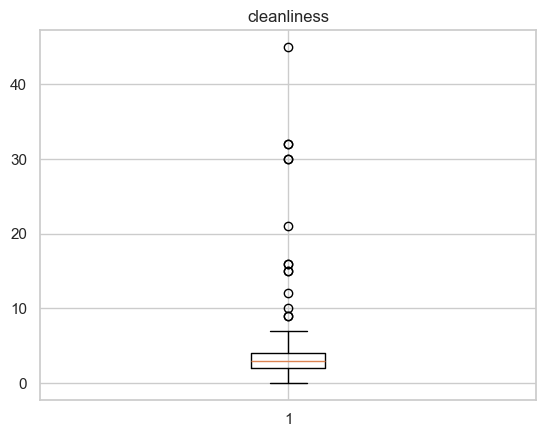

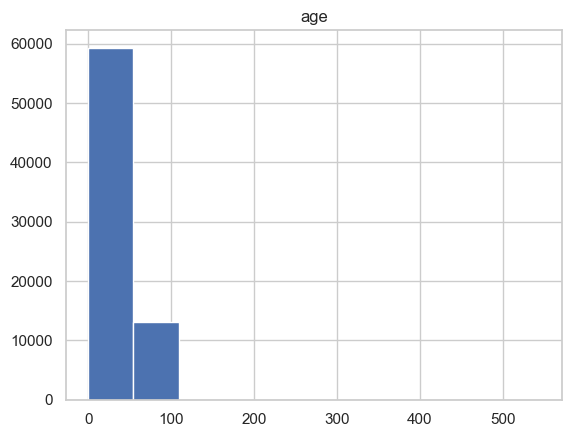

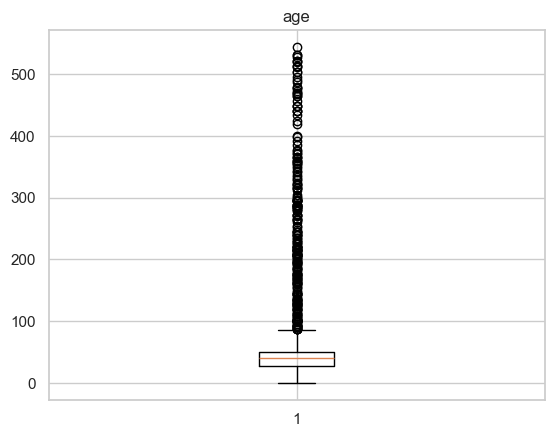

In [459]:
for col in num_cols:
    plt.hist(X_train[col])
    plt.title(col)
    plt.show()
    plt.boxplot(X_train[col])
    plt.title(col)
    plt.show()

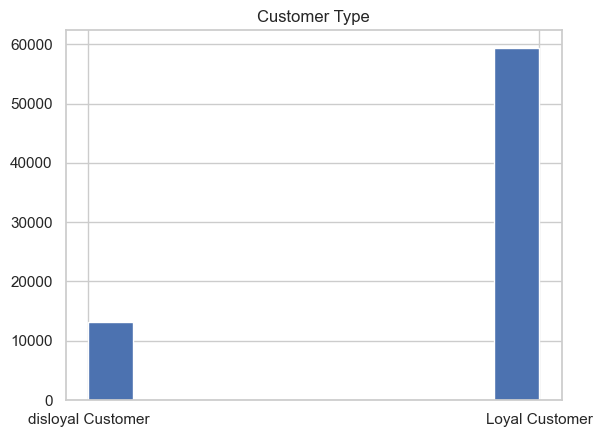

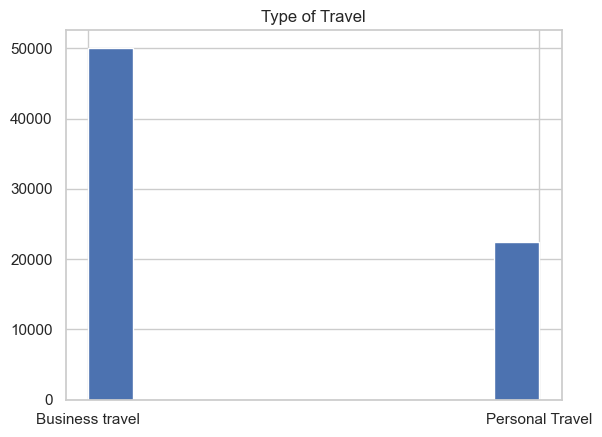

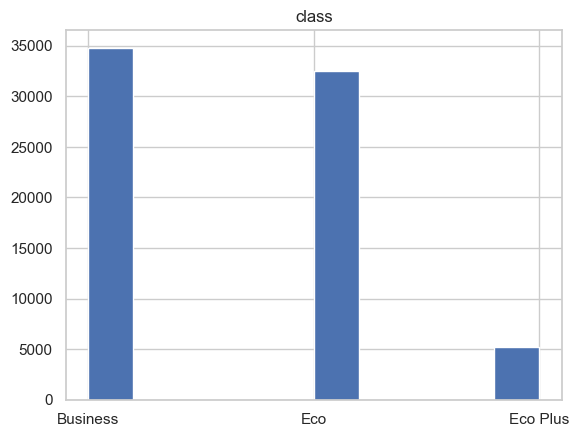

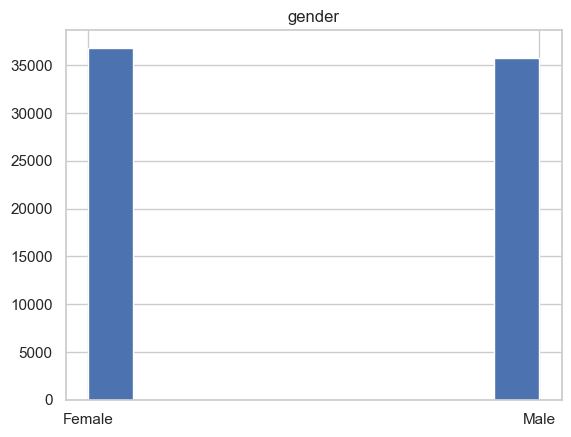

In [460]:
for col in X_train[cat_cols].columns:
    plt.hist(X_train[col])
    plt.title(col)
    plt.show()

`Вывод: распределения сильно скошены в виду наличия больших выбросово в каждом вещественном признаке. Категориальные признаки не сбалансированы, кроме признака 'gender'.`

### **Задание 11. (2 балла)**

Осуществите предобработку датасета для обучения **полностью самостоятельно**, на основе вашего опыта из прошлых дз и изученной теории. Обязательно **комментируйте** каждое действие.

**Примечание:**

В данном задании ваша задача в том числе убедить ревьюера в достаточности предобработки.

In [25]:
X_train.shape == X_train.drop_duplicates().shape, X_val.shape == X_val.drop_duplicates().shape  # -> Полных дубликатов нет

(True, True)

In [26]:
# преобразовать категориальные переменные (в y)
y_train = y_train.apply(lambda value: 1 if value == 'satisfied' else 0)
y_val = y_val.apply(lambda value: 1 if value == 'satisfied' else 0)

In [27]:
# хочу посмотреть здесь зависимость удовлетворенности от класса пассажира
satis_by_class = pd.concat([X_train[['class']], y_train], axis=1).reset_index(drop=True)
satis_by_class.groupby('class')['satisfaction'].value_counts(normalize=True)

class     satisfaction
Business  1               0.691547
          0               0.308453
Eco       0               0.812051
          1               0.187949
Eco Plus  0               0.752639
          1               0.247361
Name: proportion, dtype: float64

`Здесь вижу, что пассажиры бизнес-класса на 40% чаще довольны полетом, Eco Plus на 50% чаще недовольны полетами, а Eco - еще чаще недовольны (на 60%).`

In [28]:
# преобразовать категориальные переменные (в X)
# переменные 'Customer Type', 'Type of Travel', 'gender' закодирую OneHotEncoding, так как тут всего по 2 класса 
# а переменную 'class' закодирую LabelEncoder, так как наблюдается естественный порядок (low class (Eco), medium class (Eco plus), high class (Business)).

ohe_columns = ['Customer Type', 'Type of Travel', 'gender']
ohe = OneHotEncoder(drop='first', sparse_output=False)
ohe.fit(X_train[ohe_columns])
ohe.categories_
ohe.get_feature_names_out()
ohe_data_train = pd.DataFrame(ohe.transform(X_train[ohe_columns]), columns=ohe.get_feature_names_out()).reset_index(drop=True)
ohe_data_test = pd.DataFrame(ohe.transform(X_val[ohe_columns]), columns=ohe.get_feature_names_out()).reset_index(drop=True)
X_train = pd.concat([X_train.drop(columns=ohe_columns).reset_index(drop=True), ohe_data_train], axis=1)
X_val = pd.concat([X_val.drop(columns=ohe_columns).reset_index(drop=True), ohe_data_test], axis=1)

In [29]:
X_train['class'] = X_train['class'].apply(lambda value: 2 if value == 'Business' else 1 if value == 'Eco Plus' else 0)
X_val['class'] = X_val['class'].apply(lambda value: 2 if value == 'Business' else 1 if value == 'Eco Plus' else 0)

In [30]:
X_train.head()

class  Flight Distance  Departure Delay in Minutes  \
0      2            785.0                         0.0   
1      2           3269.0                         0.0   
2      0           1431.0                         0.0   
3      0            602.0                         0.0   
4      0            651.0                         0.0   

   Arrival Delay in Minutes  Inflight wifi service  \
0                       0.0                    2.0   
1                       0.0                    0.0   
2                       0.0                    3.0   
3                       0.0                    4.0   
4                       0.0                    5.0   

   Departure/Arrival time convenient  Ease of Online booking  Gate location  \
0                                2.0                     2.0            4.0   
1                                0.0                     0.0            3.0   
2                                1.0                     3.0            2.0   
3                                5.0                     4.0            3.0   
4                                0.0                     5.0            2.0   

   Food and drink  Online boarding  ...  On-board service  Leg room service  \
0             4.0              2.0  ...               4.0               3.0   
1             2.0              2.0  ...               3.0               3.0   
2             5.0              3.0  ...               2.0               5.0   
3             2.0              5.0  ...               4.0               4.0   
4             2.0              5.0  ...               1.0               1.0   

   Baggage handling  Checkin service  Inflight service  cleanliness   age  \
0               5.0              4.0               5.0          4.0  29.0   
1               3.0              5.0               3.0          1.0  45.0   
2               2.0              2.0               1.0          5.0   8.0   
3               2.0              3.0               4.0          3.0  48.0   
4               2.0              3.0               1.0          2.0  25.0   

   Customer Type_disloyal Customer  Type of Travel_Personal Travel  \
0                              1.0                             0.0   
1                              0.0                             0.0   
2                              0.0                             1.0   
3                              0.0                             1.0   
4                              1.0                             0.0   

   gender_Male  
0          0.0  
1          0.0  
2          1.0  
3          0.0  
4          0.0  

[5 rows x 22 columns]

**Удалим выбросы в вещественных признаках**

Здесь хочу попробовать 3 стратегии:
1. Не удалять выбросы вообще
2. Удалить выбросы, заменив экстремальные значения на значения 99 персентиля 
3. Удалить выбросы, заменив экстремальные значения на значения 75perc+1.5*IQR

После реализации каждой из стратегий буду оценивать качество случайного леса через кросс-валидацию, смотреть нижеупомянутый f1_score

In [470]:
# Стратегия № 1
X_train_ = X_train.copy()
print(cross_val_score(RandomForestClassifier(), X_train_, y_train, cv=10, scoring=make_scorer(f1_score), n_jobs=-1).mean())
rf = RandomForestClassifier()
rf.fit(X_train_, y_train)
pred = rf.predict(X_val)
f1_score(y_val, pred)

0.9542519082630351


0.9544869367663764

In [473]:
# Стратегия № 2
X_train_ = X_train.copy()
for col in num_cols:
    q99 = X_train_[col].quantile(0.99)
    X_train_.loc[X_train_[col] > q99, col] = q99
print(cross_val_score(RandomForestClassifier(), X_train_, y_train, cv=10, scoring=make_scorer(f1_score), n_jobs=-1).mean())

rf = RandomForestClassifier()
rf.fit(X_train_, y_train)
pred = rf.predict(X_val)
f1_score(y_val, pred)

0.9535651591086693


0.9528244737240649

In [475]:
# Стратегия № 3
X_train_ = X_train.copy()
for col in num_cols:
    IQR = X_train_[col].quantile(0.75) - X_train_[col].quantile(0.25)
    maximum = X_train_[col].quantile(0.75) + 1.5 * IQR
    X_train_.loc[X_train_[col] > maximum, col] = maximum
print(cross_val_score(RandomForestClassifier(), X_train_, y_train, cv=10, scoring=make_scorer(f1_score), n_jobs=-1).mean())

rf = RandomForestClassifier()
rf.fit(X_train_, y_train)
pred = rf.predict(X_val)
f1_score(y_val, pred)

0.9538828374695957


0.9537692628071637

`Наилучшее качество показала модель, где мы не трогаем выбросы :)`

### **Задание 12. (0.25 балла)**

- Обучите самописное дерево и Random Forest с базовыми гиперпараметрами. Выведите `f1-score`.

In [476]:
dt = DecisionTree(feature_types=['real']*22)
rf = RandomForestClassifier()

In [477]:
dt.fit(X_train, y_train)

In [478]:
pred_dt = dt.predict(X_val)
f1_score(y_val, pred_dt)

0.9156526024489177

In [479]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [480]:
pred_rf = rf.predict(X_val)
f1_score(y_val, pred_rf)

0.9550068171489168

`F1_score у случайного леса с гиперпараметрами по умолчанию больше на 4 сотых, чем у самописного решающего дерева.`

### **Задание 13. (0.4 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса и дерева (если реализовали их в бонусе), используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).
- Сравните качество полученных моделей и выберите лучшую. Лучшую модель сохраните в pickle.

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

`Так как на всей обучающей выборке одна модель самописного дерева обучается более 40 минут, то для кросс-валидации принял решение брать подвыборку из обучающей выборки и на ней проводить кросс-валидацию. Размер подвыборки - 10 тыс объектов (обучается примерно 6 минут).`

In [31]:
N_SAMPLES = 10_000
dt_test = DecisionTree(['real']*22)

sample_df = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1).sample(N_SAMPLES, random_state=42)
X_sample, y_sample = sample_df.drop(columns=['satisfaction']), sample_df['satisfaction']
dt_test.fit(X_sample, y_sample)
pred = dt_test.predict(X_val)
f1_score(y_val, pred)

0.8983204720835225

In [558]:
CV_counts = 4

dt_params = {
    'max_depth': np.array(uniform(1, 20).rvs(size=CV_counts, random_state=42), dtype=int),
    'min_samples_split': np.arange(2, 12, 3),
    'min_samples_leaf': np.arange(1, 11, 5)
}

rand_cv_dt = RandomizedSearchCV(DecisionTree(feature_types=['real']*22), dt_params, n_iter=10, cv=CV_counts, scoring=make_scorer(f1_score), n_jobs=-1, verbose=3, random_state=42)
rand_cv_dt.fit(X_sample, y_sample)

rand_cv_dt.best_estimator_, rand_cv_dt.best_score_

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV 2/4] END max_depth=12, min_samples_leaf=6, min_samples_split=5;, score=0.906 total time= 7.3min
[CV 2/4] END max_depth=12, min_samples_leaf=1, min_samples_split=2;, score=0.906 total time= 7.4min
[CV 2/4] END max_depth=20, min_samples_leaf=6, min_samples_split=11;, score=0.906 total time= 7.4min
[CV 3/4] END max_depth=12, min_samples_leaf=6, min_samples_split=5;, score=0.906 total time= 7.7min
[CV 3/4] END max_depth=20, min_samples_leaf=6, min_samples_split=11;, score=0.906 total time= 7.7min
[CV 3/4] END max_depth=12, min_samples_leaf=1, min_samples_split=2;, score=0.906 total time= 7.8min
[CV 1/4] END max_depth=12, min_samples_leaf=6, min_samples_split=5;, score=0.888 total time= 8.0min
[CV 1/4] END max_depth=12, min_samples_leaf=1, min_samples_split=2;, score=0.888 total time= 8.1min
[CV 1/4] END max_depth=20, min_samples_leaf=6, min_samples_split=11;, score=0.888 total time= 8.1min
[CV 4/4] END max_depth=20, min_sampl

(<hw4_code_pro.DecisionTree at 0x34a6583d0>, 0.8987337400864414)

In [561]:
rf_params = {
    'max_depth': np.array(uniform(1, 20).rvs(size=CV_counts, random_state=42), dtype=int),
    'min_samples_split': np.arange(2, 12, 3),
    'min_samples_leaf': np.arange(1, 11, 5),
    'n_estimators': [100, 200, 500],
    'max_features': ['sqrt', 'log2', None]
}

rand_cv_rf = RandomizedSearchCV(RandomForestClassifier(), rf_params, n_iter=10, cv=CV_counts, scoring=make_scorer(f1_score), n_jobs=-1, verbose=3, random_state=42)
rand_cv_rf.fit(X_sample, y_sample)

rand_cv_rf.best_estimator_, rand_cv_rf.best_score_

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV 2/4] END max_depth=8, max_features=log2, min_samples_leaf=6, min_samples_split=11, n_estimators=100;, score=0.923 total time=   0.4s
[CV 1/4] END max_depth=8, max_features=log2, min_samples_leaf=6, min_samples_split=11, n_estimators=100;, score=0.929 total time=   0.4s
[CV 3/4] END max_depth=8, max_features=log2, min_samples_leaf=6, min_samples_split=11, n_estimators=100;, score=0.918 total time=   0.5s
[CV 4/4] END max_depth=8, max_features=log2, min_samples_leaf=6, min_samples_split=11, n_estimators=100;, score=0.931 total time=   0.4s
[CV 2/4] END max_depth=8, max_features=log2, min_samples_leaf=6, min_samples_split=8, n_estimators=100;, score=0.926 total time=   0.4s
[CV 1/4] END max_depth=8, max_features=log2, min_samples_leaf=6, min_samples_split=8, n_estimators=100;, score=0.925 total time=   0.4s
[CV 3/4] END max_depth=8, max_features=log2, min_samples_leaf=6, min_samples_split=8, n_estimators=100;, score=0.919 to

(RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=500),
 0.9399597759238241)

```
Наилучший результат показал случайный лес с гиперпараметрами:
max_depth=20, min_samples_split=5, n_estimators=500
```

In [562]:
with open("best_rf_model.pickle", "wb") as file:
    pickle.dump(rand_cv_rf.best_estimator_, file)

### **Задание 14. Анализ моделей (0.1 балла)**

- Отобразите`feature_importances_` вашего лучшего случайного леса;
- Проанализируйте, какие признаки оказались важными?

In [32]:
with open('best_rf_model.pickle', "rb") as file:
    rf = pickle.load(file)

In [33]:
pd.DataFrame(rf.feature_importances_, index=X_sample.columns, columns=['feature_importance']).sort_values(by='feature_importance', ascending=False)

feature_importance
Online boarding                              0.187909
Inflight wifi service                        0.135589
class                                        0.105027
Type of Travel_Personal Travel               0.096267
Inflight entertainment                       0.054358
Seat comfort                                 0.046876
Leg room service                             0.041338
Ease of Online booking                       0.037812
Flight Distance                              0.036801
Customer Type_disloyal Customer              0.033538
On-board service                             0.032814
age                                          0.030438
cleanliness                                  0.028255
Checkin service                              0.023798
Inflight service                             0.021414
Baggage handling                             0.020445
Departure/Arrival time convenient            0.015551
Gate location                                0.013842
Arrival Delay in Minutes                     0.011882
Food and drink                               0.011781
Departure Delay in Minutes                   0.010364
gender_Male                                  0.003899

```
Наибольший вклад в модель имеют признаки: 'Online boarding' (оценка за онлайн-регистрацию?), 'Inflight wifi service' (оценка Wi-Fi во время полета) и 'class' (класс пассажирского места)
```

### **Задание 15. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [67]:
explainer = shap.TreeExplainer(rf)
sample_df = X_val.sample(1_000, random_state=42)

shap_values = explainer(sample_df)

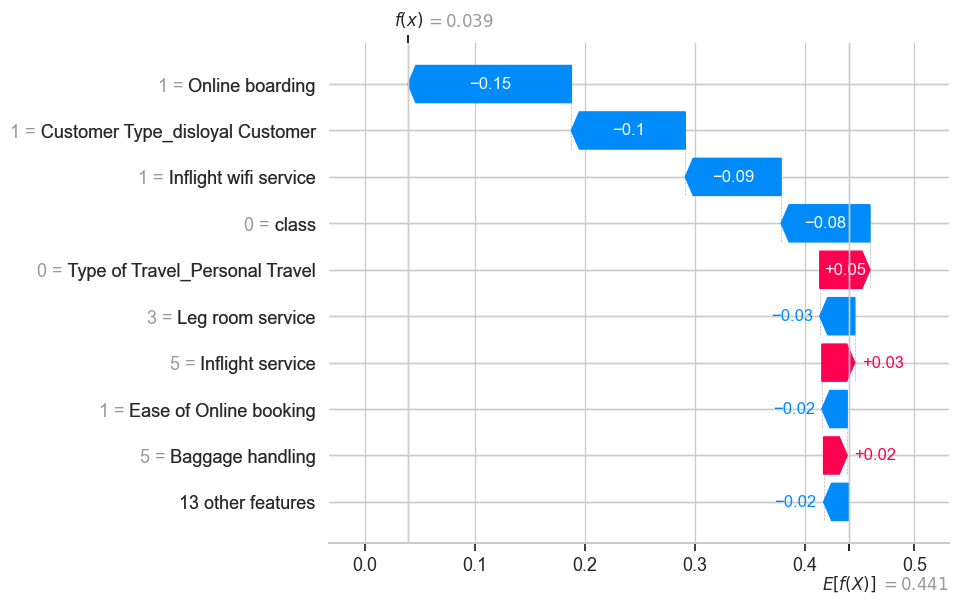

In [105]:
# feature importance для 0-го объекта
shap.waterfall_plot(shap_values[0, :, 1])

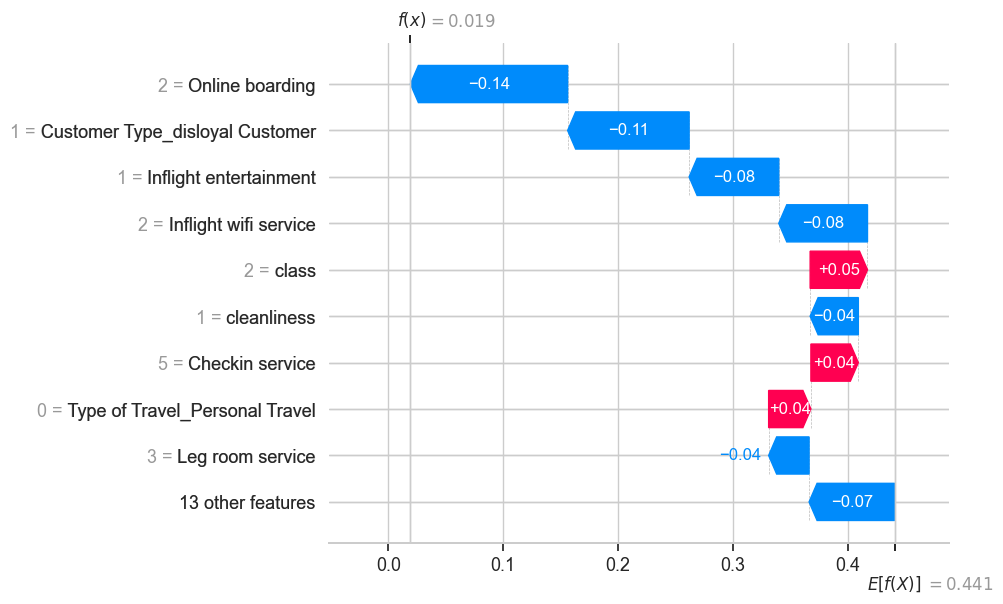

In [139]:
# feature importance для 999-го объекта
shap.waterfall_plot(shap_values[999, :, 1])

In [122]:
rf.predict(sample_df)[0], rf.predict(sample_df)[999]

(0, 0)

```
Вывел feature importance для первого и последнего объекта. Здесь видно, что наибольший вклад имеют признаки 'Online boarding', 'Customer Type_disloyal Customer' и 'Inflight wifi service'. При чем влияют они на удовлетворенность пассажиров отрицательно: прогноз для первого и последнего объектов - класс "0" (пассажиры не удовлетворены полетом). А теперь рассмотрим влияние признаков на всех объектах
```

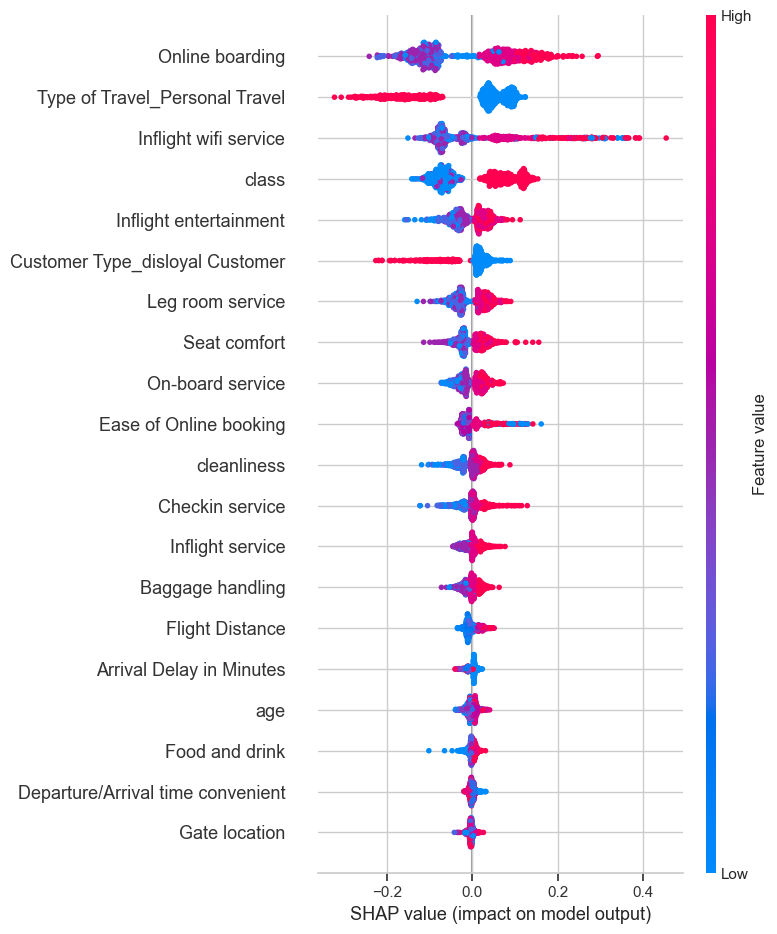

In [146]:
shap.initjs()
shap.summary_plot(shap_values[:, :, 1], sample_df, feature_names=sample_df.columns)

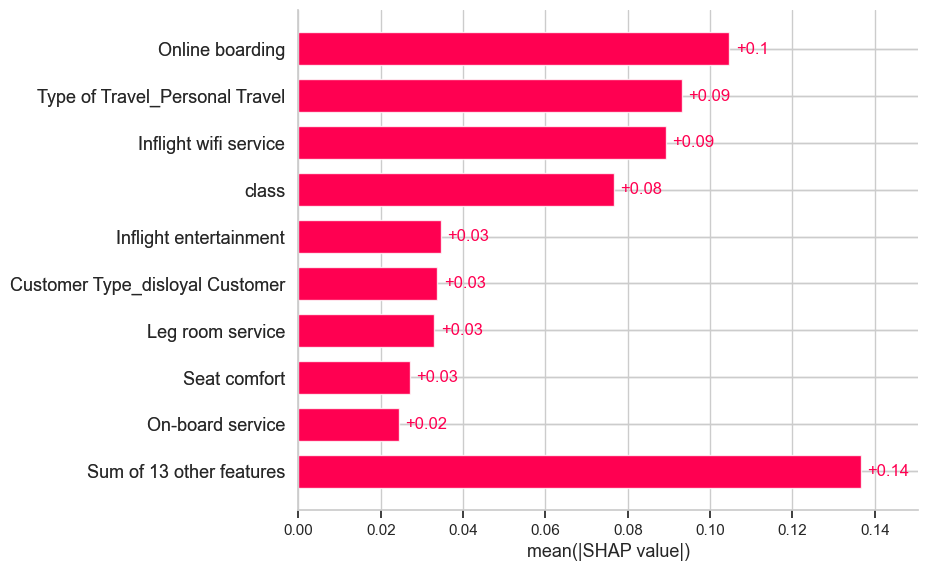

In [147]:
shap.plots.bar(shap_values[:, :, 1])

`Видим, что глобальная итерпретация показывает наибольший вклад среди признаков: 'Online boarding', 'Type of Travel_Personal Travel', 'Inflight wifi service' и 'class'. Эти 4 признака имеют наибольший вес и во встроенном методе .feature_importances_ случайного леса. Совпадение?) Не думаю.`

In [150]:
pd.DataFrame(rf.feature_importances_, index=X_sample.columns, columns=['feature_importance']).sort_values(by='feature_importance', ascending=False).head(4)

feature_importance
Online boarding                           0.187909
Inflight wifi service                     0.135589
class                                     0.105027
Type of Travel_Personal Travel            0.096267

### **Задание 16. (0.25 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

In [160]:
from lime import lime_tabular

In [165]:
explainer = lime_tabular.LimeTabularExplainer(np.array(sample_df), feature_names= sample_df.columns)
explainer

In [171]:
idx = np.random.randint(sample_df.shape[0])

explanation = explainer.explain_instance(sample_df.iloc[idx], rf.predict_proba, num_features=len(sample_df.columns))

print(f'Сделали объяснение для объекта № {idx}')

Сделали объяснение для объекта № 288


In [177]:
rf.predict(sample_df)[idx]  # предсказанный класс для данного объекта

0

In [172]:
explanation.show_in_notebook()

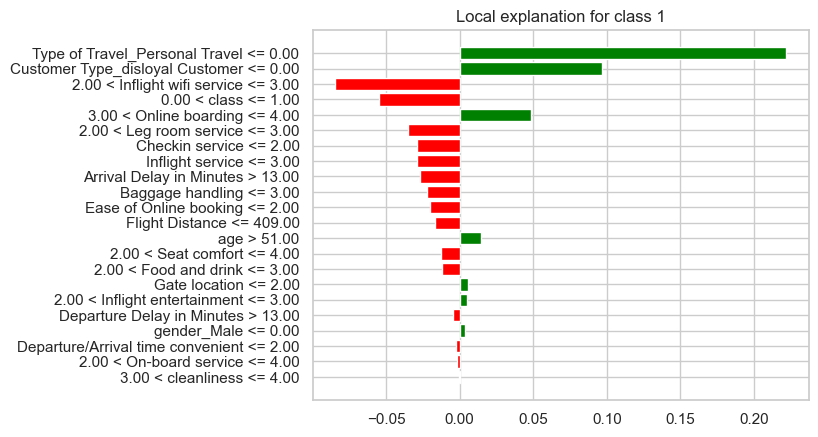

In [174]:
explanation.as_pyplot_figure()
plt.show()

```
Для объекта 288 наибольший вклад в итоговый класс оказали признаки: 'Type of Travel_Personal Travel', 'Customer Type_disloyal Customer', 'Inflight wifi service' и 'class'.
```

## Котобонус!

0.25 балла

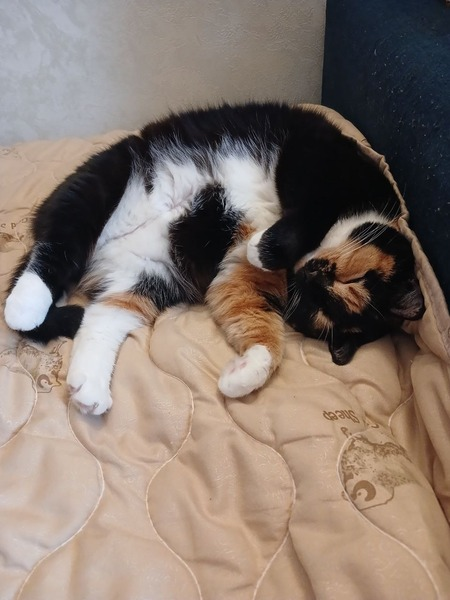

`Пусть это кот Сабины :)`

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?

- Задание прям круток, но весьма объемное (ушло больше недели на его выполнение).

- Было очень полезным: никогда не реализовывал решающие деревья руками, не использовал SHAP/LIME, RandomizedSearchCV с распределениями внутри.

- Самым сложным было реализовать решающее дерево, поскольку не знал куда подсмотреть, выполянял отталкиваясь от своего опыта. Из-за этого здесь есть сомнения правильно ли реализовал его (+правильно ли реализовал гиперпараметры). Ставлю сложности 8/10.

- Хотелось бы попробовать самостоятельно реализовать ансамбль деревьев (случайный лес), но понимаю, что это еще сложнее дерева :)